In [1]:
import numpy as np

In [166]:
def F_val(Y, A, Z, lamb, isgrad):
    # Consider Y's dimension
    if len(Y.shape) == 3:
        m_1, m_2, M = Y.shape 
        Y_hat = np.zeros([m_1, m_2, M])
    else:
        m_1, m_2 = Y.shape
        M = 1
        Y_hat = np.zeros([m_1, m_2])
        
    # Consider A's dimension
    if len(A.shape) == 3:
        K = A.shape[-1]
    else:
        K = 1
    
    g_val, F_val = np.inf, np.inf
    
    # Calculate the function value
    for t in range(M):
        for k in range(K):
            Y_hat[:, :, t] = Y_hat[:, :, t] + cconvfft2(A[:, :, k], Z[k][:, :, t])
    
    f_val = 0.5 * np.linalg.norm(Y.T.reshape([1, m_1 * m_2 * M]) - Y_hat.T.reshape([1, m_1 * m_2 * M])) ** 2
     
    return [F_val, f_val, g_val, Y_hat]

#---------------------------------------------------#

def Log_map(Z,D):
    proj_a = lambda w, z: z - innerprod(w, z) * w / np.linalg.norm(w.flatten()) ** 2
    n, K = Z.shape
    T = np.zeros([n, K])
    for k in range(K):
        alpha = np.arccos(innerprod(Z[:,:, k], D[:,:, k]))
        proj_temp = proj_a(Z[:, k], D[:, k])
        T[:,:,k] = proj_temp * alpha / np.sin(alpha)
        """
        alpha = acos(innerprod(Z(:,:,k),D(:,:,k)));
        proj_tmp =  proj_a( Z(:,k), D(:,k) ) ;
        T( :, :, k) = proj_tmp * alpha/sin(alpha) ;
        """
    
    return T

#---------------------------------------------------#

def Log_map2D(Z,D):
    proj_a = lambda w, z: z - innerprod(w, z) * w / np.linalg.norm(w.flatten()) ** 2
    # Consider Z's shape
    if len(Z.shape) == 3:
        n_1, n_2, K = Z.shape
        T = np.zeros([n_1, n_2, K])
    else:
        n_1, n_2 = Z.shape
        K = 1
        T = np.zeros([n_1, n_2])
        
    for k in range(K):
        alpha = np.arccos(innerprod(Z[:,:, k], D[:,:, k]))
        proj_temp = proj_a(Z[:, :, k], D[:, :, k])
        T[:,:,k] = proj_temp * alpha / (np.sin(alpha) + 10 ** (-20))
    
    return T

#---------------------------------------------------#

# Retraction operator
def Retract2D(A, D, tau):
    # Consider A's shape
    if len(A.shape) == 3:
        n_1, n_2, K = A.shape
        A1 = np.zeros([n_1, n_2, K])
    else:
        n_1, n_2 = A.shape
        K = 1
        A1 = np.zeros([n_1, n_2])

    for k in range(K):
        Delta = A[:,:,k] + tau[k] * D[:,:,k]
        A1[:,:,k] = Delta / np.linalg.norm(Delta.flatten())
        
    return A1

#---------------------------------------------------#

# Backtracking linesearch for updating stepsize of proximal gradient on X
def backtracking_2D(Y, A, X, fX, grad_fX, lamb, t, opts):
    # Consider Y's shape
    if len(Y.shape) == 3:
        m_1, m_2, T = Y.shape
    else:
        m_1, m_2 = A.shape
        T = 1
         
    X1 = proximal_mapping(X, grad_fX, lamb, t, opts) # proximal mapping
    X1 = thresholding(X1, opts)
    
    opts_f = {"isgrad": False}
    [psi_val, _, _] = f_quad(Y, A, X1, opts_f)
    Psi_val = psi_val + g_val(X1, lamb, opts)
    
    while Psi_val > func_quad_val(X, X1, fX, grad_fX, lamb, t, opts) and t > 1e-12:
        t = 0.5 * t
        X1 = proximal_mapping(X, grad_fX, lamb, t, opts) # proximal mapping
        X1 = thresholding(X1, opts)
        [psi_val, _, _] = f_quad(Y, A, X1, opts_f)
        Psi_val = psi_val + g_val(X1, lamb, opts)
    
    return [X1, t]

#---------------------------------------------------#
# Function value of linearization
# Dependency of backtracking
def func_quad_val(X, Z, fX, grad_fX, lamb, tau, opts):
    # Consider Z's shape
    if len(Z.shape) == 4:
        m_1, m_2, K, T = Z.shape
    elif len(Z.shape) == 3:
        m_1, m_2, K = Z.shape
        T = 1
    else:
        m_1, m_2 = Z.shape
        K = 1
        T = 1
    
    f_val = fX.copy()
    
    f_val = f_val + innerprod(grad_fX, Z - X)
    f_val = f_val + 0.5 / tau * np.sum((Z.flatten() - X.flatten()) ** 2)
    
    Z_lamb = lamb * Z
    
    case = opts["prox"].lower()
    if case == "l1":
        f_val = f_val + np.linalg.norm(Z_lamb.flatten(), 1)
    elif case == "l2":
        f_val = f_val + np.linalg.norm(Z_lamb.flatten(), 1)
        Z_lamb = lamb ##### Problem here
        f_val = f_val + np.sum(np.sqrt(np.sum(Z_lamb ** 2, 2)))
    
    return f_val

#---------------------------------------------------#
# Function of hard thresholding on X
# Dependency of backtracking
def thresholding(X, opts):
    X_val = X.copy()
    if opts["isnonnegative_X"]:
        X_val = np.maximum(X_val, 0)
        
    if opts["isupperbound"]:
        ind = X_val <= opts["hard_threshold"]
        X_val[ind] = 0
        
    return X_val

#---------------------------------------------------#
# Function of proximal operator on X
# Dependency of backtracking
def proximal_mapping(X, grad_fX, lamb, t, opts):
    # Consider X's shape
    if len(X.shape) == 4:
        m_1, m_2, K, T = X.shape
    elif len(X.shape) == 3:
        m_1, m_2, K = X.shape
    else:
        m_1, m_2 = X.shape
    
    case = opts["prox"].lower()
    if case == "l1":
        X_val = soft_thres(X - t * grad_fX, lamb * t)
    elif case == "l2":
        ##### Problem save for later
        """
        X_r = reshape(X{k}, m(1)*m(2), M);
        grad_r = reshape(grad_fX{k}, m(1)*m(2), M);
        lambda_r = reshape(lambda{k}, m(1)*m(2), M);
        X_tmp = row_soft_thres(  X_r - t * grad_r, lambda_r *t);
        X_val{k} = reshape(X_tmp, m(1), m(2), M);
        """
        pass

    return X_val

#---------------------------------------------------#
"""
CCONVFFT2 -- FFT implementation of 2D cyclic convolution
   C = cconvfft(A, B) convolves A and B using the larger size

   C = cconvfft(A, B, N)   convolves A and B using size N

   C = cconvfft(A, B, N, adj)  convolves A and B using size N, adj is a
   string chosen from: 'left', right', or 'both'. Choosing 'left' convoles
   B with the adjoint kernel of A, and vice versa. Choosing 'both'
   convolves the adjoint kernels of both A and B. 

   Both N and adj can be left empty.
"""

def cconvfft2(A, B, optinal_list = []):
    numvararg = len(optinal_list)
    
    if numvararg > 2:
        raise ValueError("Too many input arguments to unpack")
    
    N = np.maximum(A.shape, B.shape)
    if numvararg >= 1:
        N = optinal_list[0]
        
    A_hat = np.fft.fft2(A, s = N)
    B_hat = np.fft.fft2(B, s = N)
    
    if numvararg >= 2:
        if optinal_list[1] == "left":
            A_hat = np.conj(A_hat)
        elif optinal_list[1] == "right":
            B_hat = np.conj(B_hat)
        elif optinal_list[1] == "both":
            A_hat = np.conj(A_hat)
            B_hat = np.conj(B_hat)
            
    C = np.fft.ifft2(A_hat * B_hat)
    
    return C

#---------------------------------------------------#
"""
compute (Riemannian) gradient
 gradient_case = 0 for gradient of X, 
 gradient_case = 1 for gradient of A
"""
def compute_gradient(A, X, Y_b, Y_hat, gradient_case):
    proj_a = lambda W, Z: Z - np.sum(np.conj(W) * Z) * W
    
    # Consider X's shape
    if len(X.shape) == 3:
        m_1, m_2, K = X.shape
    else:
        m_1, m_2 = X.shape
        K = 1
        
    # Consider A's shape
    if len(A.shape) == 3:
        n_1, n_2, _ = A.shape
    else:
        n_1, n_2 = A.shape
    
    if gradient_case == 0:
        Grad = np.zeros([m_1, m_2, K])
    elif gradient_case == 1:
        Grad = np.zeros([n_1, n_2, K])
    
    for k in range(K):
        if gradient_case == 0:
            Grad[:, :, k] = cconvfft2(A[:,:,k], Y_hat - Y_b, optinal_list = [[m_1, m_2], "left"])
        elif gradient_case == 1:
            G = cconvfft2(X[:,:,k], Y_hat - Y_b, optinal_list = [[m_1, m_2], "left"])
            Grad[:,:,k] = proj_a(A[:,:,k], G[:n_1, :n_2])
    
    return Grad

#---------------------------------------------------#
def f_quad(Y, A, Z, opts):
    # Consider Y's shape
    if len(Y.shape) == 3:
        m_1, m_2, T = Y.shape
    else:
        m_1, m_2 = Y.shape
        T = 1
        Y = Y.reshape([m_1, m_2, T])
    
    # Consider A's shape
    if len(A.shape) == 3:
        n_1, n_2, K = A.shape
    else:
        n_1, n_2 = A.shape
        K = 1
    
    Y_hat = np.zeros([m_1,m_2,T])
    
    # Evaluate the function value
    for t in range(T):
        for k in range(K):
            Y_hat[:,:,t] = Y_hat[:,:,t] + cconvfft2(A[:,:,k], Z[:,:,k, t]) # See later
    
    F_val = 0.5 * np.linalg.norm(Y.flatten() - Y_hat.flatten()) ** 2
    
    # Evaluate the gradient
    # gradient_case = 0 for gradient of X
    # gradient_case = 1 for gradient of A
    Proj = lambda U, V: V - np.sum(np.conj(U) * V) * U / np.linalg.norm(U.flatten()) ** 2
    
    Grad = 0 # Set a default
    if opts["isgrad"]:
        case = opts["case"].lower()
        if case == "isgrad_x":
            Grad = np.zeros([m_1, m_2, K, T])
        elif case == "isgrad_a":
            Grad = np.zeros([n_1, n_2, K])
        
        for k in range(K):
            for t in range(T):
                if case == "isgrad_x":
                    Grad[:,:,k,t] = cconvfft2(A[:,:,k], Y_hat[:,:,t] - Y[:,:,t], 
                                              optinal_list = [[m_1, m_2], "left"])
                elif case == "isgrad_a":
                    G = cconvfft2(Z[:,:,k,t], Y_hat[:,:,t] - Y[:,:,t],
                                 optinal_list = [[m_1, m_2], "left"])
                    Grad[:,:,k] = Grad[:,:,k] + G[:n_1, :n_2]
            if case == "isgrad_a":
                Grad[:,:,k] = Proj(A[:,:,k], Grad[:,:,k])
        
    return [F_val, Grad, Y_hat]

#---------------------------------------------------#
def g_val(Z, lamb, opts):
    # Consider Z's shape
    if len(Z.shape) == 4:
        m_1, m_2, K, T = Z.shape
    elif len(Z.shape) == 3:
        m_1, m_2, K = Z.shape
        T = 1
    else:
        m_1, m_2 = Z.shape
        K = 1
        T = 1
    
    G_val = 0
    
    Z_lamb = np.reshape(lamb * Z, [m_1 * m_2, K, T])
    case = opts["prox"].lower()
    if case == "l1":
        G_val = np.linalg.norm(Z_lamb.flatten(), 1)
    elif case == "l2":
        for k in range(K):
            tmp = Z_lamb[:,:,k]
            G_val = G_val + np.sum(np.sqrt(np.sum(tmp ** 2, 1)))
    
    return G_val
    
#---------------------------------------------------#
def innerprod(U,V):
    T = U.flatten() * V.flatten()
    f = np.sum(T)
    
    return f

#---------------------------------------------------#
# Linesearch for updating the stepsize of Riemannian gradient on A
def linesearch_2D(Y, A, X, fA, grad_fA, opts):
    # Set parameters
    # Consider X's shape
    if len(X.shape) == 4:
        m_1, m_2, K, T = X.shape
    elif len(X.shape) == 3:
        m_1, m_2, K = X.shape
        T = 1
    else:
        m_1, m_2 = X.shape
        K = 1
        T = 1
    
    eta = 0.8
    tau = 1
    
    # Calculate the norm
    norm_grad = np.linalg.norm(grad_fA.flatten())
    
    A1 = Retract2D(A, -grad_fA, tau * np.ones([K, 1]))
    if opts["isnonnegative_A"]:
        A1 = np.maximum(A1, 0)
        
    opts_f = {"isgrad": False}
    [psi_val, _, _] = f_quad(Y, A1, X, opts_f)
    
    # Riemannian linesearch for the stepsize tau
    while psi_val > fA - eta * tau * norm_grad ** 2 and tau >= 1e-12:
        tau = 0.5 * tau
        A1 = Retract2D(A, -grad_fA, tau * np.ones([K,1]))
        if opts["isnonnegative_A"]:
            A1 = np.maximum(A1, 0)
            A1 = A1 / np.linalg.norm(A1.flatten())
        
        [psi_val, _, _] = f_quad(Y, A1, X, opts_f)
    
    return [A1, tau]

#---------------------------------------------------#
# Soft-thresholding for l12 norm
def row_soft_thres(X, lamb):
    # [~,M] = size(X);
    M = np.prod(X.shape[1:])
    norm_row = np.sqrt(np.sum(X**2, 1))
    norm_row_copy = np.hstack([norm_row] * M)
    
    X_val = np.maximum(norm_row_copy - lamb, 0) * (X / norm_row_copy)
    
    return X_val

#---------------------------------------------------#
def shift_correction_2D(A,X):
    # Consider X's shape
    if len(X.shape) == 4:
        _, _, K, T = X.shape
    elif len(X.shape) == 3:
        _, _, K = X.shape
        T = 1
    else:
        _, _ = X.shape
        K = 1
        T = 1
    
    # Consider A's shape
    if len(A.shape) == 3:
        n_1, n_2, _ = A.shape
    else:
        n_1, n_2 = A.shape
    
    n_1 = int(n_1 / 3)
    n_2 = int(n_2 / 3)
    
    A_shift = np.zeros([n_1, n_2, K])
    X_shift = np.zeros(X.shape)
    
    for k in range(K):
        Corr = np.zeros([2*n_1, 2*n_2])
        for i in range(3*n_1 - n_1):
            for j in range(3 * n_2 - n_2):
                window = A[i:i+n_1, j:j+n_2, k] # window = A(i:i+n(1)-1,j:j+n(2)-1,k);
                Corr[i,j] = np.linalg.norm(window.flatten())
        
        max_val = np.max(Corr)
        ind_1, ind_2 = np.where(Corr == max_val)
        ind_1 = int(ind_1)
        ind_2 = int(ind_2)
        # A_shift(:,:,k) = A(ind_1:ind_1+n(1)-1, ind_2:ind_2+n(2)-1,k);
        A_shift[:,:,k] = A[ind_1:ind_1 + n_1, ind_2:ind_2 + n_2, k]
        for t in range(T):
            # Use np.roll to mimic circshift
            temp = np.roll(X[:,:,k,t], ind_1 + 1, axis = 0)
            X_shift[:,:,k,t] = np.roll(temp, ind_2 + 1, axis = 1)
            # Or X_shift[:,:,k,t] = np.roll(temp, [ind_1 + 1, ind_2 + 1], axis = (0, 1))
    
    return [A_shift, X_shift]

#---------------------------------------------------#
def soft_thres(z, lamb):
    z = np.sign(z) * np.maximum(np.abs(z) - lamb, 0)
    return z

In [ ]:
def ADM_2D(Y, opts):
    # Consider Y's shape
    if len(Y.shape) == 3:
        m_1, m_2, T = Y.shape
    else:
        m_1, m_2 = Y.shape
        T = 1
        
    # Consider A_init's shape
    if len(opts["A_init"].shape) == 3:
        n_1, n_2, K = opts["A_init"].shape
    else:
        n_1, n_2 = opts["A_init"].shape
        K = 1
    
    lamb = opts["lambda"] * opts["W"]
    
    # Initialization of A, X, b, t
    A = opts["A_init"]
    X = opts["X_init"]
    b = opts["b_init"]
    t = 1 # Initialize the stepsize
    
    # Record function values
    Psi_val, psi_val = [], []
    
    for itera in range(opts["MaxIter"]):
        # Given A fixed, take a descent step on X via proximal gradient descent
        Bias = np.zeros([m_1, m_2, T])
        for k in range(T):
            Bias[:,:,k] = np.ones([m_1, m_2]) * b[k]
        
        Y_b = Y - Bias # Remove the bias from Y
        opts_F = {"isgrad": True, "case": "isgrad_X"}
        [psi_X, grad_psi_X] = f_quad(Y, A, X, opts_f)
        
        Psi_X = psi_X + g_val(X, lamb, opts)
        
        # Backtracking for update X and update stepsize t
        X_old = X.copy()
        [X, t] = backtracking_2D(Y_b, A, X, psi_X, grad_psi_X, lamb, t, opts)
        
        # Given X fixed, take a Riemannian gradient step on A
        opts_f = {"isgrad": True, "case": "isgrad_A"}
        [psi_A, grad_psi_A] = f_quad(Y, A, X, opts_f)
        Psi_A = psi_A + g_val(X, lamb, opts)
        
        # Line-search for tau
        A_old = A.copy()
        [A, tau] = linesearch_2D(Y_b, A, X, psi_A, grad_psi_A, opts)
        
        # Given A, X fixed, update the bias b
        opts_f["isgrad"] = False
        [psi, _, Y_hat] = f_quad(Y, A, X, opts_f)
        Psi = psi + g_val(X, lamb, opts)
        
        if opts["isbias"]:
            # b = mean(reshape(Y - Y_hat, m(1)*m(2),T))';
            b = np.mean(np.reshape(Y - Y_hat, [m_1 * m_2, T]), axis = 0).reshape(T, 1)
        
        # Update results and check for stopping criteria
        Psi_val.append(Psi)
        psi_val.append(psi)
        
        if opts["isdisplay"]:
            print(f"Running the {itera + 1}-th simulation, Psi_X = {Psi_X}, Psi_A = {Psi_A}...")
        
        # Check stopping criteria
        diff_A = np.linalg.norm(A.flatten() - A_old.flatten())
        diff_X = np.linalg.norm(X.flatten() - X_old.flatten())
        
        if diff_A <= opts["tol"] and diff_X <= opts["tol"]:
            break
    
    return [A, X, b, Psi_val, psi_val]

In [255]:
def iADM_2D(Y, opts):
    # Consider Y's shape
    if len(Y.shape) == 3:
        m_1, m_2, T = Y.shape
    else:
        m_1, m_2 = Y.shape
        T = 1
        Y = Y.reshape([m_1, m_2, T])
        
    # Consider A_init's shape
    if len(opts["A_init"].shape) == 4:
        n_1, n_2, K, _ = opts["A_init"].shape
    elif len(opts["A_init"].shape) == 3:
        n_1, n_2, K = opts["A_init"].shape
    else:
        n_1, n_2 = opts["A_init"].shape
        K = 1
        
    lamb = opts["lambda"] * opts["W"]
    
    # Initialization of A, X, b, t
    A = opts["A_init"]
    A_old = A.copy()
    X = opts["X_init"]
    X_old = X.copy()
    b = opts["b_init"]
    t = 1 # Initialize the stepsize
    
    # Record function values
    Psi_val, psi_val = [], []
    for itera in range(opts["MaxIter"]):
        # Given A fixed, take a descent step on X via proximal gradient descent
        Bias = np.zeros([m_1, m_2, T])
        beta = (itera - 1) / (itera + 2)
        
        X_hat = X + beta * (X - X_old)
        
        for k in range(T):
            Bias[:,:,k] = np.ones([m_1, m_2]) * b[k]
        
        Y_b = Y - Bias # Remove the bias from Y
        opts_f = {"isgrad": True, "case": "isgrad_X"}
        [psi_X, grad_psi_X, _] = f_quad(Y, A, X_hat, opts_f)
        
        Psi_X = psi_X + g_val(X_hat, lamb, opts)
        
        # Backtracking for update X and update stepsize t
        X_old = X.copy()
        [X, t] = backtracking_2D(Y_b, A, X_hat, psi_X, grad_psi_X, lamb, t, opts)
        
        # Given X fixed, take a Riemannian gradient step on A
        D = A - A_old
        A_hat = Retract2D(A, D, beta * np.ones([K, 1]))
        
        opts_f = {"isgrad": True, "case": "isgrad_A"}
        [psi_A, grad_psi_A, _] = f_quad(Y, A_hat, X, opts_f)
        Psi_A = psi_A + g_val(X, lamb, opts)
        # Line-search for tau
        [A, tau] = linesearch_2D(Y_b, A_hat, X, psi_A, grad_psi_A, opts)
        
        A_old = A.copy()
        
        # Given A, X fixed, update the bias b
        opts_f["isgrad"] = False
        [psi, _, Y_hat] = f_quad(Y, A, X, opts_f)
        Psi = psi + g_val(X, lamb, opts)
        
        if opts["isbias"]:
            b = np.mean(np.reshape(Y - Y_hat, [m_1 * m_2, T]), axis = 0).reshape(T, 1)
        
        # Update results and check for stopping criteria
        Psi_val.append(Psi)
        psi_val.append(psi)
        
        if opts["isdisplay"]:
            print(f"Running the {itera + 1}-th simulation, Psi_X = {Psi_X}, Psi_A = {Psi_A}...")
        
        # Check stopping criteria
        diff_A = np.linalg.norm(A.flatten() - A_old.flatten())
        diff_X = np.linalg.norm(X.flatten() - X_old.flatten())
        
        if diff_A <= opts["tol"] and diff_X <= opts["tol"]:
            break
    
    return [A, X, b, Psi_val, psi_val]

In [83]:
def homotopy_2D(Y, opts):
    # Consider X_init's shape
    if len(opts["X_init"].shape) == 4:
        m_1, m_2, _, T = opts["X_init"].shape
    elif len(opts["X_init"].shape) == 3:
        m_1, m_2, _ = opts["X_init"].shape
        T = 1
    else:
        m_1, m_2 = opts["X_init"].shape
        T = 1
        
    # Consider A_init's shape
    if len(opts["A_init"].shape) == 3:
        n_1, n_2, K = opts["A_init"].shape
    else:
        n_1, n_2 = opts["A_init"].shape
        K = 1
    
    Psi_Val, psi_Val = [], []
    
    homo_opts = opts.copy()
    
    # Setting parameters
    case_alg = opts["homo_alg"].lower()
    if case_alg == "adm":
        eta = 0.8
        delta = 5e-2
        homo_opts["MaxIter"] = 1e2
    elif case_alg == "iadm":
        eta = 0.8
        delta = 1e-1
        homo_opts["MaxIter"] = 1e2
    elif case_alg == "reweight":
        eta = 0.8
        delta = 0.1
        homo_opts["MaxIter"] = 2e2
    else:
        raise ValueError("Wrong algorithm")
    
    lamb_0 = 1 # Initial lambda
    lamb_tgt = opts["lambda"] # target lambda
    
    homo_opts["lambda"] = lamb_0
    homo_opts["tol"] = delta * lamb_0
    
    N_stages = np.floor(np.log(lamb_0 / lamb_gt) / np.log(1.0 / eta))
    lamb = lamb_0
    
    # Running the algorithm
    for k in range(N_stages):
        if case_alg == "adm":
            [A, X, b, Psi, psi] = ADM_2D(Y, homo_opts)
        elif case_alg == "iadm":
            [A, X, b, Psi, psi] = iADM_2D(Y, homo_opts)
        elif case_alg == "reweight":
            [A, X, b, Psi,psi,W] = reweighting_2D(y_0, homo_opts)
            homo_opts["W"] = W
        else:
            raise ValueError("Wrong algorithm")
        
        # Record result
        Psi_Val.append(Psi)
        psi_val.appeng(psi)
        
        # Update the parameters of opts
        homo_opts["A_init"] = A
        homo_opts["X_init"] = X
        homo_opts["b_init"] = b
        
        lamb = lamb * eta
        tol = delta * lamb
        homo_opts["lambda"] = lamb
        homo_opts["tol"] = tol
    
    # Solving the final stage to precision tol
    homo_opts["lambda"] = lamb_tgt
    homo_opts["tol"] = opts["tol"]
    homo_opts["MaxIter"] = opts["MaxIter"]
    
    if case_alg == "adm":
        [A, X, b, Psi, psi] = ADM_2D(Y, homo_opts)
    elif case_alg == "iadm":
        [A, X, b, Psi, psi] = iADM_2D(Y, homo_opts)
    elif case_alg == "reweight":
        [A, X, b, Psi,psi] = reweighting_2D(Y, homo_opts)
    else:
        raise ValueError("Wrong algorithm")
    
    Psi_Val.append(Psi)
    psi_val.append(psi)
    
    return [A, X, b, Psi_Val, psi_Val]

In [259]:
def reweighting_2D(Y, opts):
    Psi_Val, psi_Val = [], []
    # Consider Y's shape
    if len(Y.shape) == 3:
        m_1, m_2, T = Y.shape
    else:
        m_1, m_2 = Y.shape
        T = 1
        
    # Consider A_init's shape
    if len(opts["A_init"].shape) == 3:
        n_1, n_2, K = opts["A_init"].shape
    else:
        n_1, n_2 = opts["A_init"].shape
        K = 1
    
    M = m_1 * m_2
    N = n_1 * n_2
    
    opts["count"] = 0 # counting number of iterations
    
    for k in range(opts["MaxIter_reweight"]):
        case_alg = opts["reweight_alg"].lower()
        if case_alg == "adm":
            [A, X, b, Psi, psi] = ADM_2D(Y, opts)
        elif case_alg == "iadm":
            [A, X, b, Psi, psi] = iADM_2D(Y, opts)
        else:
            raise ValueError("Wrong algorithm")
        
        # Record result
        Psi_Val.append(Psi)
        psi_Val.append(psi)
        if opts["isdisplay"]:
            print(f"Running the {k}-th round of reweighting...")
        diff_A = opts["A_init"] - A
        diff_X = opts["X_init"] - X
        
        if np.linalg.norm(diff_A.flatten()) <= opts["tol"] and np.linalg.norm(diff_X.flatten()):
            break
        
        # Update the initialization
        opts["A_init"] = A
        opts["X_init"] = X
        opts["b_init"] = b
        opts["count"] = opts["count"] + len(psi_Val) # or psi_val
        
        # Update the weight matrix
        x = np.sort(np.abs(X.flatten()))[::-1]
        
        thres = x[int(np.round(N * K / (4 * np.log(M / N))))]
        e = np.maximum(thres, 1e-3)
        opts["W"] = 1 / (np.abs(X) + e)
        
    W = opts["W"]
    
    return [A, X, b, Psi_val, psi_val]

## Test!

In [154]:
# Test!!!!!!
# Read data
import matplotlib.pyplot as plt

def testtest(Y):

    m = np.array([512, 512]) # Size of the image
    n = np.array([20, 20]) # Size of the kernel
    K = 2 # Number of kernels / atoms
    T = 1 # NUmber of images / samples

    # Set up parameters for algorithms solving CDL problem
    opts = {}
    opts["tol"] = 1e-4                        # tolerance parameter for convergence
    opts["lambda"] = 1e-1                     # sparsity regularization parameter
    opts["isnonnegative_X"] = True            # recover a nonnegative activation map
    opts["isnonnegative_A"] = False           # recover nonnegative kernels
    opts["isbias"] = True                     # recover a constant bias
    opts["hard_thres"] = False                # parameter to set hard thresholding
    opts["MaxIter"] = int(1e3)                     # iterations and updates
    opts["isupperbound"] = False              # decision if set upper bound on X
    opts["MaxIter_reweight"] = 10             # number of max iteration for reweighting
    opts["isdisplay"] = True                  # whether display intermediate result
    opts["prox"] = 'l1'                       # choose penalization function

    alg_type = "iadm" # Choose the algorithm type 'adm','iadm',...
                      #'homotopy-adm','homotopy-iadm','reweighting-adm','reweighting-iadm'

    ## Initialization
    # Initialization for A
    opts["A_init"] = np.zeros([3 * n[0], 3 * n[1], K])
    for k in range(K):
        ind_1 = np.random.randint(0, m[0] - n[0])
        ind_2 = np.random.randint(0, m[1] - n[1])
        tmp = Y[ind_1:ind_1 + n[0], ind_2 : ind_2 + n[1]]
        tmp = tmp / np.linalg.norm(tmp.flatten())
        opts["A_init"][n[0] : 2 * n[0], n[1] : 2 * n[1], k] = tmp

    # Initialization for X, b, W
    opts["X_init"] = np.zeros([m[0], m[1], K, T])
    opts["b_init"] = np.mean(np.reshape(Y, [m[0] * m[1], T]), 0)
    opts["W"] = np.ones([m[0], m[1], K, T])

    # Solve the 2D CDL problem using one of the algorithms below
    if alg_type == "adm":
        [A, X, b, Psi_val, psi_val] = ADM_2D(Y, opts)
    elif alg_type == 'iadm':
        [A, X, b, Psi_val, psi_val] = iADM_2D(Y, opts)
    elif alg_type == 'homotopy-adm':
        opts["homo_alg"] ='ADM'
        [A, X, b, Psi_val, psi_val] = homotopy_2D(Y, opts)
    elif alg_type == 'homotopy-iadm':
        opts["homo_alg"] ='iADM'
        [A, X, b, Psi_val, psi_val] = homotopy_2D(Y, opts)
    elif alg_type == 'reweighting-adm':
        opts["reweight_alg"] = 'ADM'
        [A, X, b, Psi_val, psi_val] = reweighting_2D(Y, opts)
    elif alg_type == 'reweighting-iadm':
        opts["reweight_alg"] = 'iADM'
        [A, X, b, Psi_val, psi_val] = reweighting_2D(Y, opts)
    
    return [A, X, b, Psi_val, psi_val]

Y = plt.imread("calcium_img.png")
Y = Y / np.max(Y)
testtest(Y)
# Plot

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:306: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:310: ComplexWarning: Casting complex values to real discards the imaginary part


Running the 1-th simulation, Psi_X = 6708.743000450464, Psi_A = 2273.3210492329113...
Running the 2-th simulation, Psi_X = 2273.3210270518666, Psi_A = 1586.045497760755...
Running the 3-th simulation, Psi_X = 1499.5398227071564, Psi_A = 1397.773295830808...
Running the 4-th simulation, Psi_X = 1359.9181089890074, Psi_A = 1313.2587353966574...
Running the 5-th simulation, Psi_X = 1282.5121223823617, Psi_A = 1251.5733209464452...
Running the 6-th simulation, Psi_X = 1221.3958904345895, Psi_A = 1200.3859386324814...
Running the 7-th simulation, Psi_X = 1171.1071626096416, Psi_A = 1155.7977694404267...
Running the 8-th simulation, Psi_X = 1128.9721962963456, Psi_A = 1117.4964772607407...
Running the 9-th simulation, Psi_X = 1093.117373425442, Psi_A = 1084.067146732625...
Running the 10-th simulation, Psi_X = 1061.9936782268417, Psi_A = 1054.6493484739563...
Running the 11-th simulation, Psi_X = 1034.628236067098, Psi_A = 1028.51678492049...
Running the 12-th simulation, Psi_X = 1008.437456

Running the 97-th simulation, Psi_X = 483.19187152555537, Psi_A = 483.01350606266817...
Running the 98-th simulation, Psi_X = 482.1034182991034, Psi_A = 481.97383030644136...
Running the 99-th simulation, Psi_X = 481.2700288750591, Psi_A = 481.10825168850715...
Running the 100-th simulation, Psi_X = 479.5101234123295, Psi_A = 479.3520247817554...
Running the 101-th simulation, Psi_X = 478.3217416835879, Psi_A = 478.2005344853248...
Running the 102-th simulation, Psi_X = 477.4971797925996, Psi_A = 477.3313853820134...
Running the 103-th simulation, Psi_X = 476.00041462274356, Psi_A = 475.83428057170204...
Running the 104-th simulation, Psi_X = 474.83251860631594, Psi_A = 474.71628102726925...
Running the 105-th simulation, Psi_X = 474.0355553913525, Psi_A = 473.87926070861215...
Running the 106-th simulation, Psi_X = 472.654640764392, Psi_A = 472.50181527842886...
Running the 107-th simulation, Psi_X = 471.5510347558344, Psi_A = 471.4377852592623...
Running the 108-th simulation, Psi_X 

Running the 191-th simulation, Psi_X = 422.7186490034312, Psi_A = 422.6429463277736...
Running the 192-th simulation, Psi_X = 422.59665042337724, Psi_A = 422.52047776776277...
Running the 193-th simulation, Psi_X = 422.20115997100027, Psi_A = 422.16600084984526...
Running the 194-th simulation, Psi_X = 421.92459160247427, Psi_A = 421.88167672423276...
Running the 195-th simulation, Psi_X = 421.55526919286257, Psi_A = 421.49475985121876...
Running the 196-th simulation, Psi_X = 421.4748222614169, Psi_A = 421.41243075743125...
Running the 197-th simulation, Psi_X = 421.0814397446686, Psi_A = 421.0473632161543...
Running the 198-th simulation, Psi_X = 420.8154947015465, Psi_A = 420.7678488831274...
Running the 199-th simulation, Psi_X = 420.46678248377225, Psi_A = 420.39787082158796...
Running the 200-th simulation, Psi_X = 420.39875935982514, Psi_A = 420.32435326820234...
Running the 201-th simulation, Psi_X = 420.00341333929043, Psi_A = 419.9724137417878...
Running the 202-th simulation

Running the 285-th simulation, Psi_X = 405.0699724717732, Psi_A = 404.9992408248206...
Running the 286-th simulation, Psi_X = 404.8645489072063, Psi_A = 404.8332216469826...
Running the 287-th simulation, Psi_X = 404.7467788526407, Psi_A = 404.7120723517705...
Running the 288-th simulation, Psi_X = 404.61962985424805, Psi_A = 404.58425340907013...
Running the 289-th simulation, Psi_X = 404.6228098331192, Psi_A = 404.5880360478962...
Running the 290-th simulation, Psi_X = 404.416680100467, Psi_A = 404.39850503951277...
Running the 291-th simulation, Psi_X = 404.305047879952, Psi_A = 404.2781755374647...
Running the 292-th simulation, Psi_X = 404.16372721641324, Psi_A = 404.13026176100885...
Running the 293-th simulation, Psi_X = 404.30145646063727, Psi_A = 404.2476639907982...
Running the 294-th simulation, Psi_X = 403.99859978486097, Psi_A = 403.97864190025916...
Running the 295-th simulation, Psi_X = 403.88538805143264, Psi_A = 403.84100414347677...
Running the 296-th simulation, Psi_

Running the 379-th simulation, Psi_X = 397.9075136917259, Psi_A = 397.8750336740084...
Running the 380-th simulation, Psi_X = 398.36203392572736, Psi_A = 398.26506185232637...
Running the 381-th simulation, Psi_X = 397.9458199328866, Psi_A = 397.90667774755127...
Running the 382-th simulation, Psi_X = 397.8848807660106, Psi_A = 397.7995873276799...
Running the 383-th simulation, Psi_X = 398.0643746686798, Psi_A = 397.9579790248101...
Running the 384-th simulation, Psi_X = 397.77095939736415, Psi_A = 397.74021363487867...
Running the 385-th simulation, Psi_X = 397.718452743803, Psi_A = 397.6644127208151...
Running the 386-th simulation, Psi_X = 397.8918711871604, Psi_A = 397.8225907750205...
Running the 387-th simulation, Psi_X = 397.63949223983775, Psi_A = 397.61815976279814...
Running the 388-th simulation, Psi_X = 397.5969115688088, Psi_A = 397.55315645588377...
Running the 389-th simulation, Psi_X = 397.8354473676355, Psi_A = 397.7768832291412...
Running the 390-th simulation, Psi_X

Running the 473-th simulation, Psi_X = 394.76198476508523, Psi_A = 394.73963257182254...
Running the 474-th simulation, Psi_X = 394.72223531028067, Psi_A = 394.6897536461014...
Running the 475-th simulation, Psi_X = 395.0374851617821, Psi_A = 394.9666253376655...
Running the 476-th simulation, Psi_X = 394.71855728389465, Psi_A = 394.7003443253957...
Running the 477-th simulation, Psi_X = 394.6454704630563, Psi_A = 394.59401243922565...
Running the 478-th simulation, Psi_X = 394.6043377367886, Psi_A = 394.5365961604755...
Running the 479-th simulation, Psi_X = 394.74414713553244, Psi_A = 394.6555829696667...
Running the 480-th simulation, Psi_X = 394.51468678378336, Psi_A = 394.50078112497096...
Running the 481-th simulation, Psi_X = 394.450131590881, Psi_A = 394.4292358432415...
Running the 482-th simulation, Psi_X = 394.39046573433353, Psi_A = 394.3646321730627...
Running the 483-th simulation, Psi_X = 394.57827666985366, Psi_A = 394.5331574342529...
Running the 484-th simulation, Psi

Running the 567-th simulation, Psi_X = 391.75974970935385, Psi_A = 391.70638389758165...
Running the 568-th simulation, Psi_X = 391.61058618751474, Psi_A = 391.59467692119136...
Running the 569-th simulation, Psi_X = 391.58213977706777, Psi_A = 391.5567891877279...
Running the 570-th simulation, Psi_X = 391.90651418437767, Psi_A = 391.84906640952386...
Running the 571-th simulation, Psi_X = 391.61598596370817, Psi_A = 391.5978968776924...
Running the 572-th simulation, Psi_X = 391.5788048147751, Psi_A = 391.52808336328627...
Running the 573-th simulation, Psi_X = 391.7411542518237, Psi_A = 391.6712754587516...
Running the 574-th simulation, Psi_X = 391.53828426090746, Psi_A = 391.5202098965426...
Running the 575-th simulation, Psi_X = 391.5137920001898, Psi_A = 391.4792109185937...
Running the 576-th simulation, Psi_X = 391.6619829965198, Psi_A = 391.621227712126...
Running the 577-th simulation, Psi_X = 391.48146768843793, Psi_A = 391.4697247167036...
Running the 578-th simulation, Ps

Running the 661-th simulation, Psi_X = 390.5618617050301, Psi_A = 390.5348915803941...
Running the 662-th simulation, Psi_X = 390.52799737559485, Psi_A = 390.4854250069218...
Running the 663-th simulation, Psi_X = 390.904393560569, Psi_A = 390.8357491922486...
Running the 664-th simulation, Psi_X = 390.592615871706, Psi_A = 390.5706343581513...
Running the 665-th simulation, Psi_X = 390.5358661380308, Psi_A = 390.48360170022033...
Running the 666-th simulation, Psi_X = 390.60829296032296, Psi_A = 390.55144124422054...
Running the 667-th simulation, Psi_X = 390.4744554862428, Psi_A = 390.4443181355613...
Running the 668-th simulation, Psi_X = 390.43489852449386, Psi_A = 390.3962627694189...
Running the 669-th simulation, Psi_X = 390.4963967388717, Psi_A = 390.4608356002473...
Running the 670-th simulation, Psi_X = 390.4115266986918, Psi_A = 390.3846706257833...
Running the 671-th simulation, Psi_X = 390.29510682533527, Psi_A = 390.2716392288181...
Running the 672-th simulation, Psi_X = 

Running the 755-th simulation, Psi_X = 388.08194650588666, Psi_A = 388.0449612417286...
Running the 756-th simulation, Psi_X = 388.2653613329049, Psi_A = 388.2285740806853...
Running the 757-th simulation, Psi_X = 388.06312072957337, Psi_A = 388.05298281133867...
Running the 758-th simulation, Psi_X = 388.01523063386685, Psi_A = 387.9862948081573...
Running the 759-th simulation, Psi_X = 388.00445087563884, Psi_A = 387.9607245955584...
Running the 760-th simulation, Psi_X = 388.4092900909217, Psi_A = 388.31682954412787...
Running the 761-th simulation, Psi_X = 388.04581592717426, Psi_A = 388.0238275674962...
Running the 762-th simulation, Psi_X = 387.9918059822865, Psi_A = 387.92965688521343...
Running the 763-th simulation, Psi_X = 387.97401679147504, Psi_A = 387.8917301833325...
Running the 764-th simulation, Psi_X = 388.2082319295872, Psi_A = 388.09848509988984...
Running the 765-th simulation, Psi_X = 387.9199342595275, Psi_A = 387.90784198680507...
Running the 766-th simulation, P

Running the 849-th simulation, Psi_X = 386.76247945911757, Psi_A = 386.70596685226536...
Running the 850-th simulation, Psi_X = 386.7656613408651, Psi_A = 386.6764877731842...
Running the 851-th simulation, Psi_X = 386.84173197627365, Psi_A = 386.7921953280784...
Running the 852-th simulation, Psi_X = 386.6795592424677, Psi_A = 386.67002855617966...
Running the 853-th simulation, Psi_X = 386.6367204116781, Psi_A = 386.6190728191309...
Running the 854-th simulation, Psi_X = 386.61547024346163, Psi_A = 386.58759846188457...
Running the 855-th simulation, Psi_X = 386.98685974879095, Psi_A = 386.92293120786866...
Running the 856-th simulation, Psi_X = 386.6721202979633, Psi_A = 386.65190773472...
Running the 857-th simulation, Psi_X = 386.6207203737689, Psi_A = 386.56222473139195...
Running the 858-th simulation, Psi_X = 386.59974452397046, Psi_A = 386.5221713234487...
Running the 859-th simulation, Psi_X = 386.9896678902585, Psi_A = 386.85754151537844...
Running the 860-th simulation, Psi

Running the 943-th simulation, Psi_X = 384.9612715134291, Psi_A = 384.95167191210055...
Running the 944-th simulation, Psi_X = 384.9506537098724, Psi_A = 384.93661987964254...
Running the 945-th simulation, Psi_X = 385.0738451218668, Psi_A = 385.0518167963192...
Running the 946-th simulation, Psi_X = 384.94155625380824, Psi_A = 384.93442753235087...
Running the 947-th simulation, Psi_X = 384.89552660620717, Psi_A = 384.8774672949984...
Running the 948-th simulation, Psi_X = 384.89215796352937, Psi_A = 384.8594310074187...
Running the 949-th simulation, Psi_X = 385.02384167561144, Psi_A = 384.97520733246137...
Running the 950-th simulation, Psi_X = 384.86428955705435, Psi_A = 384.8564765519174...
Running the 951-th simulation, Psi_X = 384.81575799023864, Psi_A = 384.80005208890657...
Running the 952-th simulation, Psi_X = 384.8132797977711, Psi_A = 384.78196200228064...
Running the 953-th simulation, Psi_X = 384.886117682288, Psi_A = 384.86300778896504...
Running the 954-th simulation, 

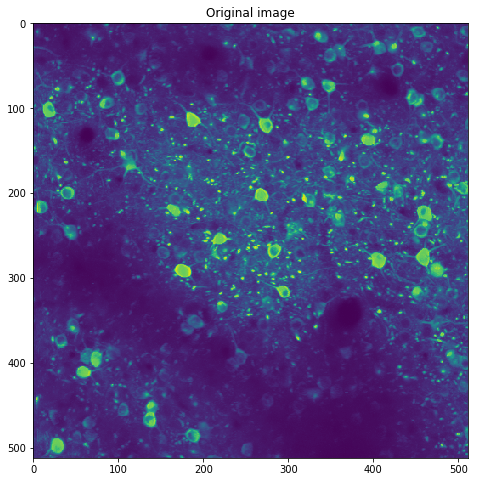

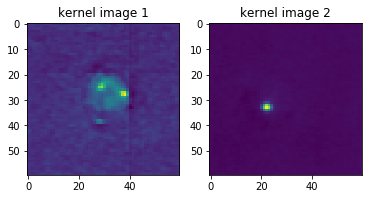

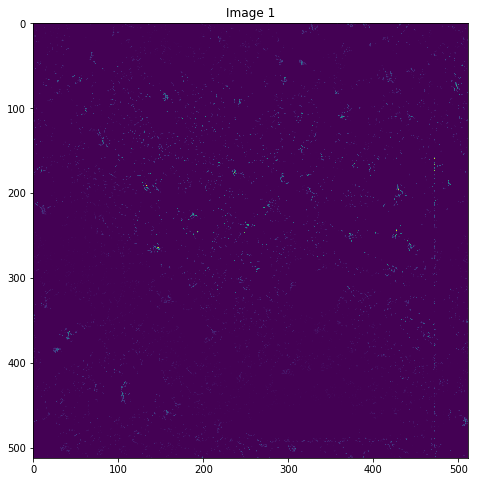

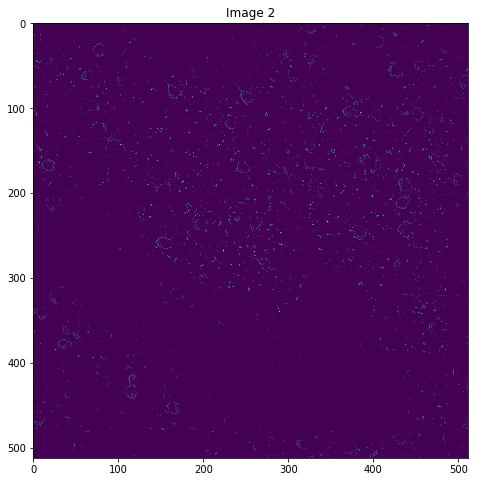

In [175]:
def plotplot(A, X, y, original = False, x_0 = 0, a_0 = 0):
    [A_shift, X_shift] = shift_correction_2D(A, X);
    
    if original:
        fig1 = plt.figure(figsize = (16, 8))
        plt.subplot(1,2,1)
        plt.imshow(x_0)
        plt.title("Original image")
        
        plt.subplot(1,2,2)
        plt.imshow(y)
        plt.title("Original blurred image")
        plt.show()
    else:

        fig2 = plt.figure(figsize = (8, 8))
        plt.imshow(y)
        plt.title("Original blurred image")
        plt.show()

    # Figure X
    for t in range(T):
        for k in range(K):
            fig = plt.figure(figsize = (8, 8))
            plt.imshow(X_shift[:,:,k, t])
            plt.title(f"Recovered image {k + 1}")
    plt.show()

    # figure(A);
    if original:
        fig1 = plt.figure(figsize = (4, 4))
        plt.imshow(np.real(a_0))
        plt.title("Original kernel")
        plt.show()
        
        for k in range(K):
            plt.subplot(1, K, k + 1)
            plt.imshow(A_shift[:,:,k])
            plt.title(f"kernel image {k + 1}")
        plt.show()
    else:
        for k in range(K):
            plt.subplot(1, K, k + 1)
            plt.imshow(A_shift[:,:,k])
            plt.title(f"Recovered kernel image {k + 1}")
        plt.show()

plotplot(A, X, Y)

## Now we test the self generated data

In [176]:
# generate the groudtruth data
# y = sum_{k=1}^K a0k conv x0k + b*1 + n
# s = rng(seed)
def gen_data_2D(theta, x_grid, n, b, noise_level, a_type,x_type, raw_data_handeling = None):
    """
    Parameters:
    ----------------
    theta: the threshold for generating spike train X_0
    x_grid: a length 2 list denoting the grid dimension for X
    n: the dimension of the kernel (we use squared kernel)
    b: the magnitude of the bias term
    noise_level: the magnitude of noise
    a_type: the kernel type we want to apply on X (randn, 2d-gaussian, sinc)
    x_type: which method we want to generate x_0 (bernoulli, bernoulli-gaussian)
    raw_data_handeling: our generated X may have some entry as negative values,
                        however, this will not happen in real image, so we need
                        to take care of those negative entries. (max_0, sigmoid)
    """
    
    # generate the kernel a_0
    gamma = [1.7, -0.712] # Parameter for AR2 model
    t = np.linspace(0, 1, n**2).reshape([n, n]) 
    case = a_type.lower()
    if case == "randn": # Random Gaussian
        a_0 = np.random.normal(size = [n, n])
    elif case == "sinc":
        sigma = 0.05
        a_0 = np.sinc((t-0.5)/sigma)
    elif case == "2d-gaussian":
        sigma = 0.5 # could perturb sigma if you want
        # 2D gaussian kernel
        grid_hori = np.linspace(-n / 2, n / 2, n)
        grid_verti = grid_hori.copy()
        mesh_x, mesh_y = np.meshgrid(grid_hori, grid_verti)
        a_0 = 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(mesh_x ** 2 + mesh_y ** 2) / 2 * sigma ** 2)
    else:
        raise ValueError("Wrong type")

    #a_0 = a_0 / np.linalg.norm(a_0, axis = 0)  # Normalize kernel by column
    a_0 = a_0 / np.max(np.linalg.eig(a_0)[0])

    # Generate the spike train x_0
    m_0, m_1 = x_grid
    case_x = x_type.lower()
    if case_x == "bernoulli":
        x_0 = (np.random.uniform(size = [m_0, m_1]) <= theta).astype(int) # Bernoulli spike train
    elif case_x == 'bernoulli-gaussian':
        # Gaussian-Bernoulli spike train
        x_0 = np.random.normal(size = [m_0, m_1]) * (np.random.uniform(size = [m_0, m_1]) <= theta)
    else:
        raise ValueError("Wrong type")
    # Now handle negative entries
    if case_x != "bernoulli":
        case_handle = raw_data_handeling.lower()
        if case_handle == "max_0":
            x_0 = np.maximum(x_0, 0)
        elif case_handle == "sigmoid":
            indices = (x_0 < 0)
            x_0[indices] = 1 / (1 + np.exp(-x_0[indices])) 

    # generate the data y = a_0 conv b_0 + bias + noise
    ##### Circular convolution alert
    y_0 = cconv(a_0, x_0, [m_0, m_1]) + b * np.ones([m_0,m_1])
    y = y_0 + np.random.normal(size = [m_0, m_1]) * noise_level
        
    return [a_0, x_0, y_0, y]

def ar2exp(g):
    # get parameters of the convolution kernel for AR2 process
    # Dependency of gen_data
    if len(g) == 1:
        g.append(0)
    temp = np.roots([1, -g[0], -g[1]]) # Polynomial roots
    d = np.max(temp)
    r = np.min(temp)
    tau_d = -1 / np.log(d)
    tau_r = -1 / np.log(r)

    tau_dr = [tau_d, tau_r]
    return np.array(tau_dr)

def cconv(mat1, mat2, output_shape):
    # Since there's a lot of functions use circular function
    # and python doesn't have a function for that
    # Dependency of gen_data
    
    return np.real((np.fft.ifft2(np.fft.fft2(mat1, s = output_shape) \
                        * np.fft.fft2(mat2, s = output_shape))))

In [177]:
b = 0.3
noise_l = 0.1
theta = 0.1
a_type = "2d-gaussian"
x_type = "bernoulli-gaussian"
raw_data_handeling = "max_0"
n = 20
x_grid = [512, 512]
[a_0, x_0, y_0, y] = gen_data_2D(theta, x_grid, n, b, noise_l, a_type,x_type, raw_data_handeling)

In [184]:
def testtest(Y, opts, m, n, k, T, alg_type):
    """
    m = # Size of the image
    n = # Size of the kernel
    K = # Number of kernels / atoms
    T = # Number of images / samples
    alg_type = "iadm" # Choose the algorithm type 'adm','iadm',...
               'homotopy-adm','homotopy-iadm','reweighting-adm','reweighting-iadm'
    """
    ## Initialization
    # Initialization for A
    opts["A_init"] = np.zeros([3 * n[0], 3 * n[1], K])
    for k in range(K):
        ind_1 = np.random.randint(0, m[0] - n[0])
        ind_2 = np.random.randint(0, m[1] - n[1])
        tmp = Y[ind_1:ind_1 + n[0], ind_2 : ind_2 + n[1]]
        tmp = tmp / np.linalg.norm(tmp.flatten())
        opts["A_init"][n[0] : 2 * n[0], n[1] : 2 * n[1], k] = tmp

    # Initialization for X, b, W
    opts["X_init"] = np.zeros([m[0], m[1], K, T])
    opts["b_init"] = np.mean(np.reshape(Y, [m[0] * m[1], T]), 0)
    opts["W"] = np.ones([m[0], m[1], K, T])

    # Solve the 2D CDL problem using one of the algorithms below
    if alg_type == "adm":
        [A, X, b, Psi_val, psi_val] = ADM_2D(Y, opts)
    elif alg_type == 'iadm':
        [A, X, b, Psi_val, psi_val] = iADM_2D(Y, opts)
    elif alg_type == 'homotopy-adm':
        opts["homo_alg"] ='ADM'
        [A, X, b, Psi_val, psi_val] = homotopy_2D(Y, opts)
    elif alg_type == 'homotopy-iadm':
        opts["homo_alg"] ='iADM'
        [A, X, b, Psi_val, psi_val] = homotopy_2D(Y, opts)
    elif alg_type == 'reweighting-adm':
        opts["reweight_alg"] = 'ADM'
        [A, X, b, Psi_val, psi_val] = reweighting_2D(Y, opts)
    elif alg_type == 'reweighting-iadm':
        opts["reweight_alg"] = 'iADM'
        [A, X, b, Psi_val, psi_val] = reweighting_2D(Y, opts)
    
    return [A, X, b, Psi_val, psi_val]

In [192]:
m = np.array([512, 512]) # Size of the image
n = np.array([20, 20]) # Size of the kernel
K = 1 # Number of kernels / atoms
T = 1 # Number of images / samples

# Set up parameters for algorithms solving CDL problem
opts = {}
opts["tol"] = 1e-4                        # tolerance parameter for convergence
opts["lambda"] = 1e-1                     # sparsity regularization parameter
opts["isnonnegative_X"] = True            # recover a nonnegative activation map
opts["isnonnegative_A"] = False           # recover nonnegative kernels
opts["isbias"] = True                     # recover a constant bias
opts["hard_thres"] = False                # parameter to set hard thresholding
opts["MaxIter"] = 3000                    # iterations and updates
opts["isupperbound"] = False              # decision if set upper bound on X
opts["MaxIter_reweight"] = 10             # number of max iteration for reweighting
opts["isdisplay"] = True                  # whether display intermediate result
opts["prox"] = 'l1'                       # choose penalization function

alg_type = "iadm" # Choose the algorithm type 'adm','iadm',...
                  #'homotopy-adm','homotopy-iadm','reweighting-adm','reweighting-iadm'
[A_data, X_data, b_data, Psi, psi] = testtest(y, opts, m, n, k, T, alg_type)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:306: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:310: ComplexWarning: Casting complex values to real discards the imaginary part


Running the 1-th simulation, Psi_X = 49558.937957072274, Psi_A = 13899.427529233766...
Running the 2-th simulation, Psi_X = 13899.423702879023, Psi_A = 8234.365656372023...
Running the 3-th simulation, Psi_X = 7558.6548723951455, Psi_A = 7257.8457167402985...
Running the 4-th simulation, Psi_X = 7051.025766778242, Psi_A = 6935.664305248376...
Running the 5-th simulation, Psi_X = 6840.626095319415, Psi_A = 6759.769800325461...
Running the 6-th simulation, Psi_X = 6682.955742245028, Psi_A = 6610.918844160042...
Running the 7-th simulation, Psi_X = 6460.420607567767, Psi_A = 6393.429855621365...
Running the 8-th simulation, Psi_X = 6291.873428013112, Psi_A = 6234.1196037760365...
Running the 9-th simulation, Psi_X = 6131.483386431678, Psi_A = 6080.72213557911...
Running the 10-th simulation, Psi_X = 5975.662428620158, Psi_A = 5931.169383954642...
Running the 11-th simulation, Psi_X = 5823.664404574656, Psi_A = 5784.66315709376...
Running the 12-th simulation, Psi_X = 5677.550461727604, Ps

Running the 96-th simulation, Psi_X = 2745.1149738291906, Psi_A = 2744.787646659105...
Running the 97-th simulation, Psi_X = 2741.7160122620926, Psi_A = 2741.432286983769...
Running the 98-th simulation, Psi_X = 2725.880175386412, Psi_A = 2725.52238811669...
Running the 99-th simulation, Psi_X = 2722.5637097162416, Psi_A = 2722.20742412427...
Running the 100-th simulation, Psi_X = 2718.2826141549085, Psi_A = 2717.9632703517764...
Running the 101-th simulation, Psi_X = 2715.0236812771054, Psi_A = 2714.7133305062425...
Running the 102-th simulation, Psi_X = 2709.7243611678196, Psi_A = 2709.4244515551504...
Running the 103-th simulation, Psi_X = 2706.572397386538, Psi_A = 2706.2744459441037...
Running the 104-th simulation, Psi_X = 2699.3148536079652, Psi_A = 2699.0036600820276...
Running the 105-th simulation, Psi_X = 2696.0043088483353, Psi_A = 2695.719651904528...
Running the 106-th simulation, Psi_X = 2693.243507645856, Psi_A = 2692.9200275541607...
Running the 107-th simulation, Psi_

Running the 190-th simulation, Psi_X = 2465.1071285609555, Psi_A = 2464.9856477291096...
Running the 191-th simulation, Psi_X = 2461.62801582956, Psi_A = 2461.5074631850457...
Running the 192-th simulation, Psi_X = 2460.2580279698586, Psi_A = 2460.1487536904524...
Running the 193-th simulation, Psi_X = 2459.016414851538, Psi_A = 2458.8937173155814...
Running the 194-th simulation, Psi_X = 2453.4214165893, Psi_A = 2453.3057090532106...
Running the 195-th simulation, Psi_X = 2452.0647797084935, Psi_A = 2451.9512787339036...
Running the 196-th simulation, Psi_X = 2450.7617752481683, Psi_A = 2450.642564894084...
Running the 197-th simulation, Psi_X = 2446.733208521264, Psi_A = 2446.560866481209...
Running the 198-th simulation, Psi_X = 2444.9587230531024, Psi_A = 2444.8333685984508...
Running the 199-th simulation, Psi_X = 2443.5376191527785, Psi_A = 2443.4200578065083...
Running the 200-th simulation, Psi_X = 2442.2329504737368, Psi_A = 2442.1049811104303...
Running the 201-th simulation,

Running the 284-th simulation, Psi_X = 2313.7257159224164, Psi_A = 2313.6484979250026...
Running the 285-th simulation, Psi_X = 2312.0214654820184, Psi_A = 2311.934391171225...
Running the 286-th simulation, Psi_X = 2311.171881918659, Psi_A = 2311.0979128808367...
Running the 287-th simulation, Psi_X = 2310.3539339970775, Psi_A = 2310.278403825994...
Running the 288-th simulation, Psi_X = 2309.382188102595, Psi_A = 2309.3019781406374...
Running the 289-th simulation, Psi_X = 2308.4184449603986, Psi_A = 2308.3439064961267...
Running the 290-th simulation, Psi_X = 2307.6362934710532, Psi_A = 2307.5653452267593...
Running the 291-th simulation, Psi_X = 2306.4085154228137, Psi_A = 2306.3256097248336...
Running the 292-th simulation, Psi_X = 2305.625737408641, Psi_A = 2305.5478525032177...
Running the 293-th simulation, Psi_X = 2303.9562218072315, Psi_A = 2303.8710706564448...
Running the 294-th simulation, Psi_X = 2303.1526349102955, Psi_A = 2303.071472004187...
Running the 295-th simulati

Running the 377-th simulation, Psi_X = 2238.600486953319, Psi_A = 2238.555635776211...
Running the 378-th simulation, Psi_X = 2237.4875900963816, Psi_A = 2237.4355960583416...
Running the 379-th simulation, Psi_X = 2237.0173544509166, Psi_A = 2236.9750760105403...
Running the 380-th simulation, Psi_X = 2236.6021760254957, Psi_A = 2236.565699456384...
Running the 381-th simulation, Psi_X = 2236.0885372711364, Psi_A = 2236.0416790802187...
Running the 382-th simulation, Psi_X = 2235.5819733886046, Psi_A = 2235.5373064056525...
Running the 383-th simulation, Psi_X = 2235.2135591208003, Psi_A = 2235.1742327997263...
Running the 384-th simulation, Psi_X = 2234.6895264420555, Psi_A = 2234.6469462188097...
Running the 385-th simulation, Psi_X = 2234.015866005343, Psi_A = 2233.975182469352...
Running the 386-th simulation, Psi_X = 2233.6457925764707, Psi_A = 2233.604815433411...
Running the 387-th simulation, Psi_X = 2233.2884959887087, Psi_A = 2233.250945596023...
Running the 388-th simulatio

Running the 471-th simulation, Psi_X = 2189.144507999984, Psi_A = 2189.1163730819767...
Running the 472-th simulation, Psi_X = 2188.7923704958657, Psi_A = 2188.76884289829...
Running the 473-th simulation, Psi_X = 2188.5427788120314, Psi_A = 2188.516952813991...
Running the 474-th simulation, Psi_X = 2188.1754361075505, Psi_A = 2188.1462447205495...
Running the 475-th simulation, Psi_X = 2187.81485942555, Psi_A = 2187.7897052325106...
Running the 476-th simulation, Psi_X = 2187.5715202023234, Psi_A = 2187.545608248622...
Running the 477-th simulation, Psi_X = 2187.2956407034744, Psi_A = 2187.2659278285355...
Running the 478-th simulation, Psi_X = 2184.0642442919493, Psi_A = 2184.041932072222...
Running the 479-th simulation, Psi_X = 2183.768827093692, Psi_A = 2183.74514178529...
Running the 480-th simulation, Psi_X = 2183.4551116599987, Psi_A = 2183.4288850788116...
Running the 481-th simulation, Psi_X = 2182.235769359795, Psi_A = 2182.202229448201...
Running the 482-th simulation, Psi

Running the 565-th simulation, Psi_X = 2144.422043224158, Psi_A = 2144.399102139836...
Running the 566-th simulation, Psi_X = 2144.0506614269684, Psi_A = 2144.029053490507...
Running the 567-th simulation, Psi_X = 2143.791117826791, Psi_A = 2143.7754440328035...
Running the 568-th simulation, Psi_X = 2143.5047780478194, Psi_A = 2143.484630895032...
Running the 569-th simulation, Psi_X = 2143.2210092004034, Psi_A = 2143.202396113329...
Running the 570-th simulation, Psi_X = 2143.01063936482, Psi_A = 2142.9920820695716...
Running the 571-th simulation, Psi_X = 2142.724669892733, Psi_A = 2142.702158521629...
Running the 572-th simulation, Psi_X = 2142.348834285878, Psi_A = 2142.326302781518...
Running the 573-th simulation, Psi_X = 2142.1084363670802, Psi_A = 2142.0888969727002...
Running the 574-th simulation, Psi_X = 2141.895252596686, Psi_A = 2141.874849921638...
Running the 575-th simulation, Psi_X = 2141.209199595435, Psi_A = 2141.1882925091977...
Running the 576-th simulation, Psi_X

Running the 659-th simulation, Psi_X = 2112.577302976715, Psi_A = 2112.556139291753...
Running the 660-th simulation, Psi_X = 2112.1061027070764, Psi_A = 2112.085048050828...
Running the 661-th simulation, Psi_X = 2111.8839923273345, Psi_A = 2111.8719247040517...
Running the 662-th simulation, Psi_X = 2111.7037809147514, Psi_A = 2111.6885204045147...
Running the 663-th simulation, Psi_X = 2111.5336322012454, Psi_A = 2111.516625623444...
Running the 664-th simulation, Psi_X = 2110.6703738874885, Psi_A = 2110.646626729942...
Running the 665-th simulation, Psi_X = 2110.3602062918135, Psi_A = 2110.3472480919...
Running the 666-th simulation, Psi_X = 2110.128879925409, Psi_A = 2110.1146200953563...
Running the 667-th simulation, Psi_X = 2109.9602817533787, Psi_A = 2109.939221684451...
Running the 668-th simulation, Psi_X = 2109.489038328412, Psi_A = 2109.468932696887...
Running the 669-th simulation, Psi_X = 2109.2743283440905, Psi_A = 2109.2602782339927...
Running the 670-th simulation, Ps

Running the 753-th simulation, Psi_X = 2081.765361672969, Psi_A = 2081.747399001759...
Running the 754-th simulation, Psi_X = 2081.6033652791994, Psi_A = 2081.588308262885...
Running the 755-th simulation, Psi_X = 2081.301679189593, Psi_A = 2081.286601089086...
Running the 756-th simulation, Psi_X = 2081.1028668524386, Psi_A = 2081.0789059152667...
Running the 757-th simulation, Psi_X = 2080.9004036713477, Psi_A = 2080.8873898541187...
Running the 758-th simulation, Psi_X = 2080.7750563161762, Psi_A = 2080.7607238851024...
Running the 759-th simulation, Psi_X = 2080.631128053874, Psi_A = 2080.6151623852115...
Running the 760-th simulation, Psi_X = 2079.688798016718, Psi_A = 2079.6700084906133...
Running the 761-th simulation, Psi_X = 2079.557905339202, Psi_A = 2079.5396541916402...
Running the 762-th simulation, Psi_X = 2079.362030904371, Psi_A = 2079.339180397954...
Running the 763-th simulation, Psi_X = 2079.1697312730666, Psi_A = 2079.1549807500296...
Running the 764-th simulation, 

Running the 847-th simulation, Psi_X = 2060.432814435482, Psi_A = 2060.420037744638...
Running the 848-th simulation, Psi_X = 2060.333975002241, Psi_A = 2060.32059261426...
Running the 849-th simulation, Psi_X = 2060.2288994031073, Psi_A = 2060.2148596316256...
Running the 850-th simulation, Psi_X = 2058.9867988032847, Psi_A = 2058.964266317249...
Running the 851-th simulation, Psi_X = 2058.7559164557733, Psi_A = 2058.742138201707...
Running the 852-th simulation, Psi_X = 2058.5809551801926, Psi_A = 2058.568081165247...
Running the 853-th simulation, Psi_X = 2058.4695841642633, Psi_A = 2058.4516150955023...
Running the 854-th simulation, Psi_X = 2058.2293834855977, Psi_A = 2058.209598215695...
Running the 855-th simulation, Psi_X = 2058.0293787372207, Psi_A = 2058.0167698535597...
Running the 856-th simulation, Psi_X = 2057.9134504882827, Psi_A = 2057.897860909251...
Running the 857-th simulation, Psi_X = 2057.689177559108, Psi_A = 2057.6715894692593...
Running the 858-th simulation, P

Running the 940-th simulation, Psi_X = 2039.528457562536, Psi_A = 2039.5131845973692...
Running the 941-th simulation, Psi_X = 2038.6136431914122, Psi_A = 2038.5962512097858...
Running the 942-th simulation, Psi_X = 2038.4343157631947, Psi_A = 2038.4211376970156...
Running the 943-th simulation, Psi_X = 2038.3113451860213, Psi_A = 2038.2952924325336...
Running the 944-th simulation, Psi_X = 2038.1950414694732, Psi_A = 2038.1765649864756...
Running the 945-th simulation, Psi_X = 2037.9967647278513, Psi_A = 2037.9824775084276...
Running the 946-th simulation, Psi_X = 2037.8824167171074, Psi_A = 2037.8679102061665...
Running the 947-th simulation, Psi_X = 2037.7753728901657, Psi_A = 2037.7595224992315...
Running the 948-th simulation, Psi_X = 2037.4318966795522, Psi_A = 2037.4134427630715...
Running the 949-th simulation, Psi_X = 2037.3411413032231, Psi_A = 2037.3253917940783...
Running the 950-th simulation, Psi_X = 2037.2059268089447, Psi_A = 2037.1917285573477...
Running the 951-th sim

Running the 1033-th simulation, Psi_X = 2029.596717806845, Psi_A = 2029.5857475345429...
Running the 1034-th simulation, Psi_X = 2029.5627003211926, Psi_A = 2029.5495560544446...
Running the 1035-th simulation, Psi_X = 2029.5816623186824, Psi_A = 2029.5598533390216...
Running the 1036-th simulation, Psi_X = 2029.4297313219856, Psi_A = 2029.416680313143...
Running the 1037-th simulation, Psi_X = 2029.334618662836, Psi_A = 2029.323521771727...
Running the 1038-th simulation, Psi_X = 2029.3056670952615, Psi_A = 2029.291339314635...
Running the 1039-th simulation, Psi_X = 2029.3140391255984, Psi_A = 2029.2967047523452...
Running the 1040-th simulation, Psi_X = 2029.1899370169172, Psi_A = 2029.1789791054512...
Running the 1041-th simulation, Psi_X = 2029.1594073321548, Psi_A = 2029.1458267389426...
Running the 1042-th simulation, Psi_X = 2029.2063437209754, Psi_A = 2029.1884038157832...
Running the 1043-th simulation, Psi_X = 2029.0496998270332, Psi_A = 2029.0382517703247...
Running the 104

Running the 1125-th simulation, Psi_X = 2025.0858958147219, Psi_A = 2025.0782324484608...
Running the 1126-th simulation, Psi_X = 2025.0566146773858, Psi_A = 2025.0473164292107...
Running the 1127-th simulation, Psi_X = 2025.0329961093157, Psi_A = 2025.0209304483506...
Running the 1128-th simulation, Psi_X = 2025.0516603795272, Psi_A = 2025.039797057469...
Running the 1129-th simulation, Psi_X = 2024.9741107739774, Psi_A = 2024.966031008932...
Running the 1130-th simulation, Psi_X = 2024.9490452938974, Psi_A = 2024.9396238359457...
Running the 1131-th simulation, Psi_X = 2024.9289992089805, Psi_A = 2024.9204147537016...
Running the 1132-th simulation, Psi_X = 2024.8609068974306, Psi_A = 2024.8539722991893...
Running the 1133-th simulation, Psi_X = 2024.8369474448443, Psi_A = 2024.8277613442162...
Running the 1134-th simulation, Psi_X = 2024.8978824649166, Psi_A = 2024.8810743619051...
Running the 1135-th simulation, Psi_X = 2024.766454168601, Psi_A = 2024.755920780255...
Running the 11

Running the 1217-th simulation, Psi_X = 2021.8108436405182, Psi_A = 2021.8011850267696...
Running the 1218-th simulation, Psi_X = 2021.842151142667, Psi_A = 2021.8330253033275...
Running the 1219-th simulation, Psi_X = 2021.7685756350793, Psi_A = 2021.762571160757...
Running the 1220-th simulation, Psi_X = 2021.7478618372702, Psi_A = 2021.7405159374662...
Running the 1221-th simulation, Psi_X = 2021.7513835434224, Psi_A = 2021.7445762506914...
Running the 1222-th simulation, Psi_X = 2021.687775159698, Psi_A = 2021.6825881235613...
Running the 1223-th simulation, Psi_X = 2021.667882437508, Psi_A = 2021.6607912356535...
Running the 1224-th simulation, Psi_X = 2021.7629217396834, Psi_A = 2021.7490261597968...
Running the 1225-th simulation, Psi_X = 2021.581879078521, Psi_A = 2021.5772254996243...
Running the 1226-th simulation, Psi_X = 2021.5569061956116, Psi_A = 2021.5501195662025...
Running the 1227-th simulation, Psi_X = 2021.5411970451228, Psi_A = 2021.5316334300442...
Running the 122

Running the 1309-th simulation, Psi_X = 2019.3756450301971, Psi_A = 2019.3718120137914...
Running the 1310-th simulation, Psi_X = 2019.3559903354617, Psi_A = 2019.35060141019...
Running the 1311-th simulation, Psi_X = 2019.342751122424, Psi_A = 2019.3352123796299...
Running the 1312-th simulation, Psi_X = 2019.377514601998, Psi_A = 2019.3703016054856...
Running the 1313-th simulation, Psi_X = 2019.30897516699, Psi_A = 2019.3055925650874...
Running the 1314-th simulation, Psi_X = 2019.2919097594272, Psi_A = 2019.2859708868727...
Running the 1315-th simulation, Psi_X = 2019.401678518183, Psi_A = 2019.3899366531568...
Running the 1316-th simulation, Psi_X = 2019.2263199989625, Psi_A = 2019.2229022062859...
Running the 1317-th simulation, Psi_X = 2019.2041371776486, Psi_A = 2019.1985512238912...
Running the 1318-th simulation, Psi_X = 2019.1928676901985, Psi_A = 2019.1854231313637...
Running the 1319-th simulation, Psi_X = 2019.2865800496888, Psi_A = 2019.2695029738245...
Running the 1320-

Running the 1401-th simulation, Psi_X = 2017.344492005187, Psi_A = 2017.3382871106646...
Running the 1402-th simulation, Psi_X = 2017.4042178090858, Psi_A = 2017.3930896434363...
Running the 1403-th simulation, Psi_X = 2017.2624379840372, Psi_A = 2017.259758223549...
Running the 1404-th simulation, Psi_X = 2017.2447091280305, Psi_A = 2017.2395643467867...
Running the 1405-th simulation, Psi_X = 2017.2353164179399, Psi_A = 2017.2286700293407...
Running the 1406-th simulation, Psi_X = 2017.2713736060255, Psi_A = 2017.266787013124...
Running the 1407-th simulation, Psi_X = 2017.2108682608286, Psi_A = 2017.2075717382054...
Running the 1408-th simulation, Psi_X = 2017.1963555913185, Psi_A = 2017.1915617356244...
Running the 1409-th simulation, Psi_X = 2017.213532051892, Psi_A = 2017.2100789360447...
Running the 1410-th simulation, Psi_X = 2017.1638228990118, Psi_A = 2017.1613633887168...
Running the 1411-th simulation, Psi_X = 2017.1500461664914, Psi_A = 2017.1456799833418...
Running the 14

Running the 1493-th simulation, Psi_X = 2015.9263420895472, Psi_A = 2015.9224679670667...
Running the 1494-th simulation, Psi_X = 2015.9195205956087, Psi_A = 2015.9132940646336...
Running the 1495-th simulation, Psi_X = 2015.95146117914, Psi_A = 2015.946605169032...
Running the 1496-th simulation, Psi_X = 2015.8980871152764, Psi_A = 2015.8955833483383...
Running the 1497-th simulation, Psi_X = 2015.8856282342813, Psi_A = 2015.8820568998863...
Running the 1498-th simulation, Psi_X = 2015.9756759349857, Psi_A = 2015.9677309667875...
Running the 1499-th simulation, Psi_X = 2015.8400242549742, Psi_A = 2015.8378237492266...
Running the 1500-th simulation, Psi_X = 2015.8243456131272, Psi_A = 2015.8204306954585...
Running the 1501-th simulation, Psi_X = 2015.8167945933815, Psi_A = 2015.8115613296864...
Running the 1502-th simulation, Psi_X = 2015.8228883212278, Psi_A = 2015.8146484656163...
Running the 1503-th simulation, Psi_X = 2015.717740968451, Psi_A = 2015.7156967652072...
Running the 15

Running the 1585-th simulation, Psi_X = 2014.603106674466, Psi_A = 2014.601096268208...
Running the 1586-th simulation, Psi_X = 2014.5893991607072, Psi_A = 2014.5858690522314...
Running the 1587-th simulation, Psi_X = 2014.584263583497, Psi_A = 2014.5785486220166...
Running the 1588-th simulation, Psi_X = 2014.6260587962288, Psi_A = 2014.6202162562436...
Running the 1589-th simulation, Psi_X = 2014.5665478705882, Psi_A = 2014.5647706356585...
Running the 1590-th simulation, Psi_X = 2014.5559865937719, Psi_A = 2014.5526380339...
Running the 1591-th simulation, Psi_X = 2014.575276335443, Psi_A = 2014.5721149566073...
Running the 1592-th simulation, Psi_X = 2014.5301625319325, Psi_A = 2014.5282149585555...
Running the 1593-th simulation, Psi_X = 2014.5198397471, Psi_A = 2014.5167220031626...
Running the 1594-th simulation, Psi_X = 2014.6003468479921, Psi_A = 2014.5933001777885...
Running the 1595-th simulation, Psi_X = 2014.4817059343186, Psi_A = 2014.4799095205121...
Running the 1596-th 

Running the 1677-th simulation, Psi_X = 2013.6116689325067, Psi_A = 2013.6102042145394...
Running the 1678-th simulation, Psi_X = 2013.6021402017254, Psi_A = 2013.5994213234687...
Running the 1679-th simulation, Psi_X = 2013.6252470135848, Psi_A = 2013.6228671488134...
Running the 1680-th simulation, Psi_X = 2013.5801313779375, Psi_A = 2013.5790871588274...
Running the 1681-th simulation, Psi_X = 2013.571665132137, Psi_A = 2013.5688576336074...
Running the 1682-th simulation, Psi_X = 2013.666426966738, Psi_A = 2013.6587303586957...
Running the 1683-th simulation, Psi_X = 2013.5403206938695, Psi_A = 2013.538959321529...
Running the 1684-th simulation, Psi_X = 2013.527607241197, Psi_A = 2013.524692653139...
Running the 1685-th simulation, Psi_X = 2013.5240952267868, Psi_A = 2013.5189407648422...
Running the 1686-th simulation, Psi_X = 2013.570032052387, Psi_A = 2013.5645071327606...
Running the 1687-th simulation, Psi_X = 2013.5100899888394, Psi_A = 2013.5085036736843...
Running the 1688

Running the 1769-th simulation, Psi_X = 2012.7604440055022, Psi_A = 2012.757352262748...
Running the 1770-th simulation, Psi_X = 2012.758372218551, Psi_A = 2012.7527413383218...
Running the 1771-th simulation, Psi_X = 2012.8055940697436, Psi_A = 2012.8001211106375...
Running the 1772-th simulation, Psi_X = 2012.7455344784335, Psi_A = 2012.7441989819445...
Running the 1773-th simulation, Psi_X = 2012.7369232112937, Psi_A = 2012.7341418690673...
Running the 1774-th simulation, Psi_X = 2012.769042849805, Psi_A = 2012.7662985333882...
Running the 1775-th simulation, Psi_X = 2012.7194951726765, Psi_A = 2012.7183496424686...
Running the 1776-th simulation, Psi_X = 2012.7111929785283, Psi_A = 2012.7086387053496...
Running the 1777-th simulation, Psi_X = 2012.8507438620968, Psi_A = 2012.8412883025012...
Running the 1778-th simulation, Psi_X = 2012.6914541947922, Psi_A = 2012.6900358535736...
Running the 1779-th simulation, Psi_X = 2012.6774744895984, Psi_A = 2012.6740292497975...
Running the 1

Running the 1861-th simulation, Psi_X = 2012.0415230045007, Psi_A = 2012.0387012382523...
Running the 1862-th simulation, Psi_X = 2012.082311214716, Psi_A = 2012.07942454168...
Running the 1863-th simulation, Psi_X = 2012.0269165616523, Psi_A = 2012.0260573096177...
Running the 1864-th simulation, Psi_X = 2012.0193741846706, Psi_A = 2012.0166113278947...
Running the 1865-th simulation, Psi_X = 2012.0517148602348, Psi_A = 2012.0491161346472...
Running the 1866-th simulation, Psi_X = 2012.0034781942459, Psi_A = 2012.0027341240643...
Running the 1867-th simulation, Psi_X = 2011.9959917953606, Psi_A = 2011.9933755757575...
Running the 1868-th simulation, Psi_X = 2012.1322052393452, Psi_A = 2012.1234207164098...
Running the 1869-th simulation, Psi_X = 2011.9792125536678, Psi_A = 2011.9780680018216...
Running the 1870-th simulation, Psi_X = 2011.9656965542877, Psi_A = 2011.9625680206175...
Running the 1871-th simulation, Psi_X = 2011.9644687595523, Psi_A = 2011.9587989618235...
Running the 1

Running the 1953-th simulation, Psi_X = 2011.372005408536, Psi_A = 2011.3660806235084...
Running the 1954-th simulation, Psi_X = 2011.4243537676375, Psi_A = 2011.418220208849...
Running the 1955-th simulation, Psi_X = 2011.3621069009846, Psi_A = 2011.3608960694369...
Running the 1956-th simulation, Psi_X = 2011.3554010544583, Psi_A = 2011.3525668175462...
Running the 1957-th simulation, Psi_X = 2011.4020211005284, Psi_A = 2011.398829862026...
Running the 1958-th simulation, Psi_X = 2011.3438818461532, Psi_A = 2011.3429436375445...
Running the 1959-th simulation, Psi_X = 2011.3372708713, Psi_A = 2011.334532844425...
Running the 1960-th simulation, Psi_X = 2011.3801697371616, Psi_A = 2011.377606638257...
Running the 1961-th simulation, Psi_X = 2011.325196284161, Psi_A = 2011.324398788944...
Running the 1962-th simulation, Psi_X = 2011.318700859344, Psi_A = 2011.3159112856815...
Running the 1963-th simulation, Psi_X = 2011.3562630182691, Psi_A = 2011.353522792847...
Running the 1964-th si

Running the 2045-th simulation, Psi_X = 2010.7976684782948, Psi_A = 2010.7967167591187...
Running the 2046-th simulation, Psi_X = 2010.7897331162671, Psi_A = 2010.7873852816224...
Running the 2047-th simulation, Psi_X = 2010.8228453417287, Psi_A = 2010.8205894538426...
Running the 2048-th simulation, Psi_X = 2010.7769319055337, Psi_A = 2010.7762362332976...
Running the 2049-th simulation, Psi_X = 2010.7695667356602, Psi_A = 2010.7674070147905...
Running the 2050-th simulation, Psi_X = 2010.8942692367443, Psi_A = 2010.8866210069054...
Running the 2051-th simulation, Psi_X = 2010.7561671712967, Psi_A = 2010.7554715594679...
Running the 2052-th simulation, Psi_X = 2010.7441384916842, Psi_A = 2010.7413604357403...
Running the 2053-th simulation, Psi_X = 2010.7433820939154, Psi_A = 2010.7382094645104...
Running the 2054-th simulation, Psi_X = 2010.7957395768146, Psi_A = 2010.7899554473674...
Running the 2055-th simulation, Psi_X = 2010.734143785553, Psi_A = 2010.7329918374598...
Running the

Running the 2137-th simulation, Psi_X = 2010.2538330332127, Psi_A = 2010.2511863319255...
Running the 2138-th simulation, Psi_X = 2010.2999781971994, Psi_A = 2010.2973187873336...
Running the 2139-th simulation, Psi_X = 2010.2439963957136, Psi_A = 2010.2433192716167...
Running the 2140-th simulation, Psi_X = 2010.237475695213, Psi_A = 2010.2349263248534...
Running the 2141-th simulation, Psi_X = 2010.276833157555, Psi_A = 2010.2742405396452...
Running the 2142-th simulation, Psi_X = 2010.2266975268453, Psi_A = 2010.226125811439...
Running the 2143-th simulation, Psi_X = 2010.2201601613656, Psi_A = 2010.217907107634...
Running the 2144-th simulation, Psi_X = 2010.2497344783233, Psi_A = 2010.2478900142696...
Running the 2145-th simulation, Psi_X = 2010.2084178632194, Psi_A = 2010.2076975364675...
Running the 2146-th simulation, Psi_X = 2010.2016950153993, Psi_A = 2010.19961532951...
Running the 2147-th simulation, Psi_X = 2010.3112696345497, Psi_A = 2010.304695636087...
Running the 2148-

Running the 2229-th simulation, Psi_X = 2009.7657993057414, Psi_A = 2009.7649952226793...
Running the 2230-th simulation, Psi_X = 2009.7525771082805, Psi_A = 2009.7495411795048...
Running the 2231-th simulation, Psi_X = 2009.753467996844, Psi_A = 2009.7477994278047...
Running the 2232-th simulation, Psi_X = 2009.8125542187702, Psi_A = 2009.8061985533009...
Running the 2233-th simulation, Psi_X = 2009.7460490412109, Psi_A = 2009.7449025259307...
Running the 2234-th simulation, Psi_X = 2009.739597282442, Psi_A = 2009.7366635836502...
Running the 2235-th simulation, Psi_X = 2009.7931104212635, Psi_A = 2009.790111565425...
Running the 2236-th simulation, Psi_X = 2009.7313639255713, Psi_A = 2009.7308306796122...
Running the 2237-th simulation, Psi_X = 2009.7253098748386, Psi_A = 2009.7226341352666...
Running the 2238-th simulation, Psi_X = 2009.7754614888695, Psi_A = 2009.7725940829055...
Running the 2239-th simulation, Psi_X = 2009.7170288218992, Psi_A = 2009.7163033105612...
Running the 2

Running the 2321-th simulation, Psi_X = 2009.2967186195485, Psi_A = 2009.2945761205995...
Running the 2322-th simulation, Psi_X = 2009.3302450833853, Psi_A = 2009.3282962408618...
Running the 2323-th simulation, Psi_X = 2009.2865931282277, Psi_A = 2009.2861342043238...
Running the 2324-th simulation, Psi_X = 2009.27981247764, Psi_A = 2009.2777914120209...
Running the 2325-th simulation, Psi_X = 2009.3925532722267, Psi_A = 2009.3859732706105...
Running the 2326-th simulation, Psi_X = 2009.2698367934554, Psi_A = 2009.2692739870708...
Running the 2327-th simulation, Psi_X = 2009.2587345293439, Psi_A = 2009.2564746647322...
Running the 2328-th simulation, Psi_X = 2009.2581829263704, Psi_A = 2009.2537328267144...
Running the 2329-th simulation, Psi_X = 2009.3109210649582, Psi_A = 2009.3053862059492...
Running the 2330-th simulation, Psi_X = 2009.2511860538516, Psi_A = 2009.2500026078974...
Running the 2331-th simulation, Psi_X = 2009.2428763801308, Psi_A = 2009.2408851587688...
Running the 

Running the 2413-th simulation, Psi_X = 2008.8639163736334, Psi_A = 2008.859071309966...
Running the 2414-th simulation, Psi_X = 2008.9493686226742, Psi_A = 2008.9419334337385...
Running the 2415-th simulation, Psi_X = 2008.861268523906, Psi_A = 2008.8601677342508...
Running the 2416-th simulation, Psi_X = 2008.8577563503763, Psi_A = 2008.8544085041808...
Running the 2417-th simulation, Psi_X = 2008.9730174315314, Psi_A = 2008.966037315538...
Running the 2418-th simulation, Psi_X = 2008.8593757574731, Psi_A = 2008.8585545676913...
Running the 2419-th simulation, Psi_X = 2008.8545071188114, Psi_A = 2008.851464473179...
Running the 2420-th simulation, Psi_X = 2008.854670969522, Psi_A = 2008.8509528997865...
Running the 2421-th simulation, Psi_X = 2008.9736284066194, Psi_A = 2008.9671558367777...
Running the 2422-th simulation, Psi_X = 2008.8560092915377, Psi_A = 2008.8552735795315...
Running the 2423-th simulation, Psi_X = 2008.8502519498825, Psi_A = 2008.8472975822026...
Running the 242

Running the 2505-th simulation, Psi_X = 2008.5346811268446, Psi_A = 2008.5286745601084...
Running the 2506-th simulation, Psi_X = 2008.4718967611611, Psi_A = 2008.4708050656386...
Running the 2507-th simulation, Psi_X = 2008.465566613053, Psi_A = 2008.462904027624...
Running the 2508-th simulation, Psi_X = 2008.5147492059782, Psi_A = 2008.5121633000622...
Running the 2509-th simulation, Psi_X = 2008.4590180925343, Psi_A = 2008.4585408617538...
Running the 2510-th simulation, Psi_X = 2008.4532262976563, Psi_A = 2008.4507771876683...
Running the 2511-th simulation, Psi_X = 2008.495559977368, Psi_A = 2008.493265830094...
Running the 2512-th simulation, Psi_X = 2008.445825225067, Psi_A = 2008.445445288733...
Running the 2513-th simulation, Psi_X = 2008.4398762151668, Psi_A = 2008.4377912491445...
Running the 2514-th simulation, Psi_X = 2008.4724625085464, Psi_A = 2008.4706615558844...
Running the 2515-th simulation, Psi_X = 2008.431417365324, Psi_A = 2008.4309813513173...
Running the 2516-

Running the 2597-th simulation, Psi_X = 2008.1156514234144, Psi_A = 2008.1151862639886...
Running the 2598-th simulation, Psi_X = 2008.1096415211437, Psi_A = 2008.1072118450002...
Running the 2599-th simulation, Psi_X = 2008.146346774739, Psi_A = 2008.1446473164137...
Running the 2600-th simulation, Psi_X = 2008.1025192159361, Psi_A = 2008.1019995256215...
Running the 2601-th simulation, Psi_X = 2008.0962346682625, Psi_A = 2008.094097670095...
Running the 2602-th simulation, Psi_X = 2008.2228989202672, Psi_A = 2008.2160952392942...
Running the 2603-th simulation, Psi_X = 2008.0927302790387, Psi_A = 2008.0922878960414...
Running the 2604-th simulation, Psi_X = 2008.0814664103045, Psi_A = 2008.0791930467626...
Running the 2605-th simulation, Psi_X = 2008.081958178123, Psi_A = 2008.0771598892516...
Running the 2606-th simulation, Psi_X = 2008.1377554656242, Psi_A = 2008.1323406606898...
Running the 2607-th simulation, Psi_X = 2008.0760422798348, Psi_A = 2008.075031718465...
Running the 26

Running the 2689-th simulation, Psi_X = 2007.7395582217266, Psi_A = 2007.7390623071296...
Running the 2690-th simulation, Psi_X = 2007.7336014968203, Psi_A = 2007.7314308003465...
Running the 2691-th simulation, Psi_X = 2007.8840585160906, Psi_A = 2007.8753302171513...
Running the 2692-th simulation, Psi_X = 2007.732570733352, Psi_A = 2007.732116600197...
Running the 2693-th simulation, Psi_X = 2007.7207481388405, Psi_A = 2007.7182033604972...
Running the 2694-th simulation, Psi_X = 2007.7224029907247, Psi_A = 2007.717175657773...
Running the 2695-th simulation, Psi_X = 2007.7804057504482, Psi_A = 2007.7744476181388...
Running the 2696-th simulation, Psi_X = 2007.717203697056, Psi_A = 2007.7161811867832...
Running the 2697-th simulation, Psi_X = 2007.7110617402445, Psi_A = 2007.7084921533651...
Running the 2698-th simulation, Psi_X = 2007.7624099005293, Psi_A = 2007.759859034536...
Running the 2699-th simulation, Psi_X = 2007.7061485697736, Psi_A = 2007.7057319630512...
Running the 270

Running the 2781-th simulation, Psi_X = 2007.4426884797972, Psi_A = 2007.4406362675559...
Running the 2782-th simulation, Psi_X = 2007.4846728590846, Psi_A = 2007.4825520699724...
Running the 2783-th simulation, Psi_X = 2007.436425048942, Psi_A = 2007.4360137866097...
Running the 2784-th simulation, Psi_X = 2007.4296409389228, Psi_A = 2007.4275641053882...
Running the 2785-th simulation, Psi_X = 2007.5645168261021, Psi_A = 2007.5570196422482...
Running the 2786-th simulation, Psi_X = 2007.427166763628, Psi_A = 2007.426711537915...
Running the 2787-th simulation, Psi_X = 2007.415570883761, Psi_A = 2007.4131601641325...
Running the 2788-th simulation, Psi_X = 2007.4163198198441, Psi_A = 2007.4115704554254...
Running the 2789-th simulation, Psi_X = 2007.4781667678733, Psi_A = 2007.471539532602...
Running the 2790-th simulation, Psi_X = 2007.4115726021935, Psi_A = 2007.4104247063228...
Running the 2791-th simulation, Psi_X = 2007.4036150957209, Psi_A = 2007.401539008693...
Running the 2792

Running the 2873-th simulation, Psi_X = 2007.1222809887909, Psi_A = 2007.1169786072628...
Running the 2874-th simulation, Psi_X = 2007.180901413059, Psi_A = 2007.1750872923144...
Running the 2875-th simulation, Psi_X = 2007.117759849679, Psi_A = 2007.1168408246263...
Running the 2876-th simulation, Psi_X = 2007.1122528234228, Psi_A = 2007.1096061967187...
Running the 2877-th simulation, Psi_X = 2007.1671050722555, Psi_A = 2007.1639590847703...
Running the 2878-th simulation, Psi_X = 2007.1087532035658, Psi_A = 2007.1082905622832...
Running the 2879-th simulation, Psi_X = 2007.1035936541198, Psi_A = 2007.1011163268697...
Running the 2880-th simulation, Psi_X = 2007.1536741990524, Psi_A = 2007.1512192832217...
Running the 2881-th simulation, Psi_X = 2007.0995062629522, Psi_A = 2007.099195715446...
Running the 2882-th simulation, Psi_X = 2007.094222860896, Psi_A = 2007.0920250124072...
Running the 2883-th simulation, Psi_X = 2007.137688855009, Psi_A = 2007.1354068883238...
Running the 288

Running the 2965-th simulation, Psi_X = 2006.9104682015447, Psi_A = 2006.9094543479412...
Running the 2966-th simulation, Psi_X = 2006.9073898327233, Psi_A = 2006.9050807807698...
Running the 2967-th simulation, Psi_X = 2007.0153180355824, Psi_A = 2007.0106790844075...
Running the 2968-th simulation, Psi_X = 2006.905626563882, Psi_A = 2006.9050313331536...
Running the 2969-th simulation, Psi_X = 2006.897296741644, Psi_A = 2006.8947093568254...
Running the 2970-th simulation, Psi_X = 2006.8976167777078, Psi_A = 2006.8928435990456...
Running the 2971-th simulation, Psi_X = 2006.9384547445716, Psi_A = 2006.9350264940308...
Running the 2972-th simulation, Psi_X = 2006.8914069618609, Psi_A = 2006.8905752219453...
Running the 2973-th simulation, Psi_X = 2006.8844481377303, Psi_A = 2006.8822705487123...
Running the 2974-th simulation, Psi_X = 2007.0104570669707, Psi_A = 2007.004464569819...
Running the 2975-th simulation, Psi_X = 2006.8835558536744, Psi_A = 2006.8830555516752...
Running the 2

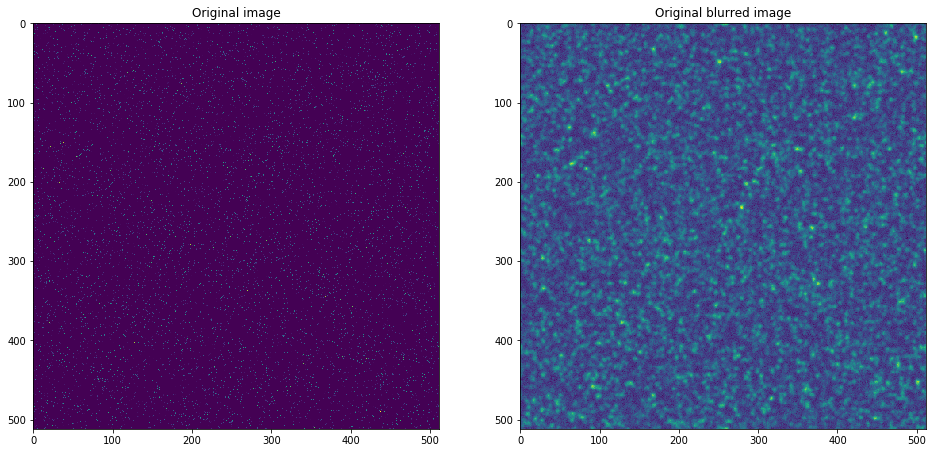

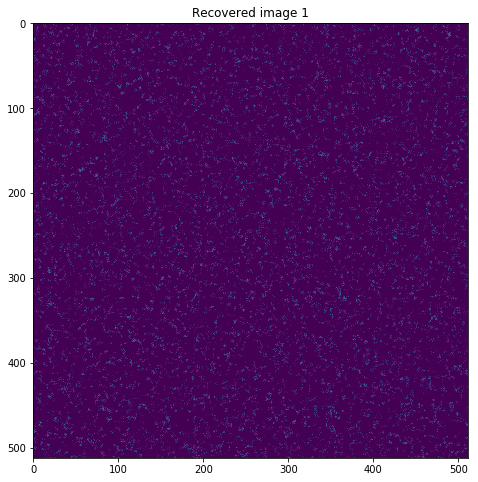

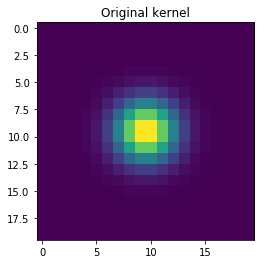

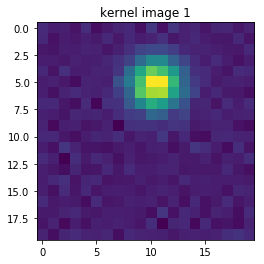

In [212]:
plotplot(A_data, X_data, y, original = True, x_0 = x_0, a_0 = a_0)

In [230]:
print(f"Sparsity level of recovered X :{np.sum(X_data != 0) / np.prod(X_data.shape)}")
print(f"Sparsity level of Original X :{np.sum(x_0 != 0) / np.prod(x_0.shape)}")

Sparsity level of recovered X :0.20875167846679688
Sparsity level of Original X :0.049404144287109375


In [261]:
b = 0.3
noise_l = 0.1
theta = 0.03
a_type = "2d-gaussian"
x_type = "bernoulli-gaussian"
raw_data_handeling = "max_0"
n = np.array([20, 20]) 
x_grid = [512, 512]
[a_1, x_1, y_1, y_noise] = gen_data_2D(theta, x_grid, 20, b, noise_l, a_type,x_type, raw_data_handeling)

opts["MaxIter"] = 3000                    # iterations and updates

[A2_data, X2_data, b2_data, Psi, psi] = testtest(y_noise, opts, m, n, k, T, alg_type)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:306: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:310: ComplexWarning: Casting complex values to real discards the imaginary part


Running the 1-th simulation, Psi_X = 22316.28629379561, Psi_A = 11555.004533702888...
Running the 2-th simulation, Psi_X = 9240.377343355163, Psi_A = 4477.1154158710115...
Running the 3-th simulation, Psi_X = 3886.9766426900305, Psi_A = 3646.7342281956194...
Running the 4-th simulation, Psi_X = 3476.7534130264803, Psi_A = 3448.2536413736816...
Running the 5-th simulation, Psi_X = 3395.485341567326, Psi_A = 3383.1376563597996...
Running the 6-th simulation, Psi_X = 3365.042378422456, Psi_A = 3355.5269448423755...
Running the 7-th simulation, Psi_X = 3344.9665786959386, Psi_A = 3335.5151202052693...
Running the 8-th simulation, Psi_X = 3322.6499880666497, Psi_A = 3314.2359439940788...
Running the 9-th simulation, Psi_X = 3300.6216966639427, Psi_A = 3292.7049598019403...
Running the 10-th simulation, Psi_X = 3275.308265262564, Psi_A = 3268.371194032299...
Running the 11-th simulation, Psi_X = 3252.0990070825105, Psi_A = 3245.6774372673226...
Running the 12-th simulation, Psi_X = 3228.7208

Running the 96-th simulation, Psi_X = 2096.7058406643064, Psi_A = 2096.587815131603...
Running the 97-th simulation, Psi_X = 2092.181023558961, Psi_A = 2092.0370523853585...
Running the 98-th simulation, Psi_X = 2089.8034777190605, Psi_A = 2089.688275196824...
Running the 99-th simulation, Psi_X = 2085.778531293902, Psi_A = 2085.6377774361276...
Running the 100-th simulation, Psi_X = 2083.406420180083, Psi_A = 2083.2949595284044...
Running the 101-th simulation, Psi_X = 2079.7645101089474, Psi_A = 2079.6230897481137...
Running the 102-th simulation, Psi_X = 2077.398706925822, Psi_A = 2077.2899780044545...
Running the 103-th simulation, Psi_X = 2074.0698397682845, Psi_A = 2073.9286103169734...
Running the 104-th simulation, Psi_X = 2071.696240160785, Psi_A = 2071.58946223353...
Running the 105-th simulation, Psi_X = 2068.523797795652, Psi_A = 2068.3918411300606...
Running the 106-th simulation, Psi_X = 2066.2478025495975, Psi_A = 2066.145717148173...
Running the 107-th simulation, Psi_X

Running the 189-th simulation, Psi_X = 1936.4257146800987, Psi_A = 1936.386025734374...
Running the 190-th simulation, Psi_X = 1935.4565937426598, Psi_A = 1935.420660270168...
Running the 191-th simulation, Psi_X = 1934.5988754062976, Psi_A = 1934.5623588285507...
Running the 192-th simulation, Psi_X = 1933.514005959669, Psi_A = 1933.4717804075756...
Running the 193-th simulation, Psi_X = 1932.4689735879497, Psi_A = 1932.434116697333...
Running the 194-th simulation, Psi_X = 1931.6239050983952, Psi_A = 1931.5874065592611...
Running the 195-th simulation, Psi_X = 1930.689220300731, Psi_A = 1930.6516379880034...
Running the 196-th simulation, Psi_X = 1929.7523654901117, Psi_A = 1929.7181951108723...
Running the 197-th simulation, Psi_X = 1928.7566651308764, Psi_A = 1928.7192602500177...
Running the 198-th simulation, Psi_X = 1927.8319152262475, Psi_A = 1927.7992049815552...
Running the 199-th simulation, Psi_X = 1927.0196525042675, Psi_A = 1926.9856422204775...
Running the 200-th simulat

Running the 282-th simulation, Psi_X = 1855.3551734496236, Psi_A = 1855.3305984142378...
Running the 283-th simulation, Psi_X = 1854.6737281362516, Psi_A = 1854.6486151028616...
Running the 284-th simulation, Psi_X = 1853.961351668834, Psi_A = 1853.9385111132322...
Running the 285-th simulation, Psi_X = 1853.2987193023305, Psi_A = 1853.273648655199...
Running the 286-th simulation, Psi_X = 1852.6194341213945, Psi_A = 1852.5969496591729...
Running the 287-th simulation, Psi_X = 1852.0028985581798, Psi_A = 1851.9796005089975...
Running the 288-th simulation, Psi_X = 1850.6954529562236, Psi_A = 1850.6709200998218...
Running the 289-th simulation, Psi_X = 1849.9680349194293, Psi_A = 1849.9463687915388...
Running the 290-th simulation, Psi_X = 1849.3128565191494, Psi_A = 1849.2885823504762...
Running the 291-th simulation, Psi_X = 1848.6435009252875, Psi_A = 1848.6207363942347...
Running the 292-th simulation, Psi_X = 1848.0168373005245, Psi_A = 1847.9939192296406...
Running the 293-th simu

Running the 375-th simulation, Psi_X = 1786.9531482402735, Psi_A = 1786.9353176879629...
Running the 376-th simulation, Psi_X = 1786.4141201490365, Psi_A = 1786.3938510232379...
Running the 377-th simulation, Psi_X = 1785.7162430313183, Psi_A = 1785.6972198991925...
Running the 378-th simulation, Psi_X = 1785.1004233077506, Psi_A = 1785.0827437461803...
Running the 379-th simulation, Psi_X = 1784.566266723896, Psi_A = 1784.5452780745359...
Running the 380-th simulation, Psi_X = 1783.8619199875775, Psi_A = 1783.8420012440438...
Running the 381-th simulation, Psi_X = 1783.2502950355934, Psi_A = 1783.2321926706313...
Running the 382-th simulation, Psi_X = 1782.7170583433729, Psi_A = 1782.6975460301383...
Running the 383-th simulation, Psi_X = 1782.0028294858223, Psi_A = 1781.9844743289996...
Running the 384-th simulation, Psi_X = 1781.3989097453768, Psi_A = 1781.3814056271424...
Running the 385-th simulation, Psi_X = 1780.8685823824462, Psi_A = 1780.8490869157183...
Running the 386-th sim

Running the 468-th simulation, Psi_X = 1733.1031840932537, Psi_A = 1733.0897456510277...
Running the 469-th simulation, Psi_X = 1732.6657682356854, Psi_A = 1732.6522258300515...
Running the 470-th simulation, Psi_X = 1732.1735611975919, Psi_A = 1732.1604444436782...
Running the 471-th simulation, Psi_X = 1731.7382492079132, Psi_A = 1731.7248868309973...
Running the 472-th simulation, Psi_X = 1731.1489231439796, Psi_A = 1731.1360856521128...
Running the 473-th simulation, Psi_X = 1730.709439480408, Psi_A = 1730.6963037369667...
Running the 474-th simulation, Psi_X = 1730.2826702375492, Psi_A = 1730.2681550313232...
Running the 475-th simulation, Psi_X = 1729.8096092756177, Psi_A = 1729.7943809459994...
Running the 476-th simulation, Psi_X = 1729.3855155118965, Psi_A = 1729.3722336618412...
Running the 477-th simulation, Psi_X = 1728.9626146191836, Psi_A = 1728.9487288304863...
Running the 478-th simulation, Psi_X = 1728.4841258561087, Psi_A = 1728.471021022256...
Running the 479-th simu

Running the 561-th simulation, Psi_X = 1696.7308880113403, Psi_A = 1696.7214641338433...
Running the 562-th simulation, Psi_X = 1696.4227126972487, Psi_A = 1696.4133107872694...
Running the 563-th simulation, Psi_X = 1696.174154621835, Psi_A = 1696.1645613466587...
Running the 564-th simulation, Psi_X = 1695.8245548042669, Psi_A = 1695.8148936251614...
Running the 565-th simulation, Psi_X = 1695.5177231335206, Psi_A = 1695.509223507479...
Running the 566-th simulation, Psi_X = 1695.274419962017, Psi_A = 1695.2654385110602...
Running the 567-th simulation, Psi_X = 1694.9365953299175, Psi_A = 1694.9272124450526...
Running the 568-th simulation, Psi_X = 1694.6333812771106, Psi_A = 1694.624603967096...
Running the 569-th simulation, Psi_X = 1694.394118583378, Psi_A = 1694.3856394438692...
Running the 570-th simulation, Psi_X = 1694.0666555901682, Psi_A = 1694.058329388954...
Running the 571-th simulation, Psi_X = 1693.7665708724824, Psi_A = 1693.7581934267523...
Running the 572-th simulati

Running the 654-th simulation, Psi_X = 1675.743030835802, Psi_A = 1675.737461313147...
Running the 655-th simulation, Psi_X = 1675.5285660455554, Psi_A = 1675.5236630129332...
Running the 656-th simulation, Psi_X = 1675.3958469690629, Psi_A = 1675.389616822678...
Running the 657-th simulation, Psi_X = 1675.2519771363404, Psi_A = 1675.2462428745403...
Running the 658-th simulation, Psi_X = 1675.0421555419662, Psi_A = 1675.0373259338896...
Running the 659-th simulation, Psi_X = 1674.9119566639602, Psi_A = 1674.9057158485923...
Running the 660-th simulation, Psi_X = 1674.7688518045688, Psi_A = 1674.7630254562805...
Running the 661-th simulation, Psi_X = 1674.564588630055, Psi_A = 1674.5591451875016...
Running the 662-th simulation, Psi_X = 1674.4364620016318, Psi_A = 1674.4301740210744...
Running the 663-th simulation, Psi_X = 1674.2943033048891, Psi_A = 1674.2885040185256...
Running the 664-th simulation, Psi_X = 1674.0947285208472, Psi_A = 1674.0895315408197...
Running the 665-th simula

Running the 747-th simulation, Psi_X = 1663.1046495951962, Psi_A = 1663.0998560811968...
Running the 748-th simulation, Psi_X = 1662.9500247129677, Psi_A = 1662.9458127153166...
Running the 749-th simulation, Psi_X = 1662.85177836999, Psi_A = 1662.8478625605708...
Running the 750-th simulation, Psi_X = 1662.7804235363114, Psi_A = 1662.7761515184698...
Running the 751-th simulation, Psi_X = 1662.5826788833574, Psi_A = 1662.5788168227289...
Running the 752-th simulation, Psi_X = 1662.482259232668, Psi_A = 1662.4781214344655...
Running the 753-th simulation, Psi_X = 1662.3964828383878, Psi_A = 1662.3923123269174...
Running the 754-th simulation, Psi_X = 1662.2707490919797, Psi_A = 1662.2664915639123...
Running the 755-th simulation, Psi_X = 1662.1209414438167, Psi_A = 1662.116525735792...
Running the 756-th simulation, Psi_X = 1662.0245672879928, Psi_A = 1662.0200021957735...
Running the 757-th simulation, Psi_X = 1661.952544737376, Psi_A = 1661.9474106260527...
Running the 758-th simulat

Running the 840-th simulation, Psi_X = 1652.5716272103011, Psi_A = 1652.5682642109368...
Running the 841-th simulation, Psi_X = 1652.5075069341376, Psi_A = 1652.5033840801002...
Running the 842-th simulation, Psi_X = 1652.3054332834754, Psi_A = 1652.30127248506...
Running the 843-th simulation, Psi_X = 1652.1914726402924, Psi_A = 1652.1878530457375...
Running the 844-th simulation, Psi_X = 1652.0957040795402, Psi_A = 1652.0917466206738...
Running the 845-th simulation, Psi_X = 1652.0153553941827, Psi_A = 1652.012209546222...
Running the 846-th simulation, Psi_X = 1651.8799501235742, Psi_A = 1651.8768876330428...
Running the 847-th simulation, Psi_X = 1651.7789146537518, Psi_A = 1651.7752156840575...
Running the 848-th simulation, Psi_X = 1651.7350757737609, Psi_A = 1651.731211208285...
Running the 849-th simulation, Psi_X = 1651.5700049144152, Psi_A = 1651.5664413967954...
Running the 850-th simulation, Psi_X = 1651.4658181680222, Psi_A = 1651.4623910426444...
Running the 851-th simula

Running the 933-th simulation, Psi_X = 1642.6080102755957, Psi_A = 1642.604524613987...
Running the 934-th simulation, Psi_X = 1642.555716656825, Psi_A = 1642.552789354139...
Running the 935-th simulation, Psi_X = 1642.4480231522994, Psi_A = 1642.4445137288221...
Running the 936-th simulation, Psi_X = 1642.3574033296165, Psi_A = 1642.3536888319513...
Running the 937-th simulation, Psi_X = 1642.223186484242, Psi_A = 1642.219639126261...
Running the 938-th simulation, Psi_X = 1642.1709925236917, Psi_A = 1642.1686046640134...
Running the 939-th simulation, Psi_X = 1642.0631684624318, Psi_A = 1642.0606459533792...
Running the 940-th simulation, Psi_X = 1641.9731525963662, Psi_A = 1641.9699618154514...
Running the 941-th simulation, Psi_X = 1641.8356474328752, Psi_A = 1641.8321269134328...
Running the 942-th simulation, Psi_X = 1641.757844480485, Psi_A = 1641.754277566396...
Running the 943-th simulation, Psi_X = 1641.6723576753984, Psi_A = 1641.6693685281853...
Running the 944-th simulatio

Running the 1026-th simulation, Psi_X = 1633.9193804505026, Psi_A = 1633.9169034646075...
Running the 1027-th simulation, Psi_X = 1633.827571652797, Psi_A = 1633.825591125144...
Running the 1028-th simulation, Psi_X = 1633.7520068403655, Psi_A = 1633.7493072185919...
Running the 1029-th simulation, Psi_X = 1633.6611961908086, Psi_A = 1633.6580390525035...
Running the 1030-th simulation, Psi_X = 1633.5800211448282, Psi_A = 1633.5769346976176...
Running the 1031-th simulation, Psi_X = 1633.489711343625, Psi_A = 1633.487295273254...
Running the 1032-th simulation, Psi_X = 1633.41409447645, Psi_A = 1633.4122218734713...
Running the 1033-th simulation, Psi_X = 1633.324081183392, Psi_A = 1633.3216066064992...
Running the 1034-th simulation, Psi_X = 1633.2411190087964, Psi_A = 1633.2389360416007...
Running the 1035-th simulation, Psi_X = 1633.1532121104349, Psi_A = 1633.1514469732929...
Running the 1036-th simulation, Psi_X = 1633.0796467654404, Psi_A = 1633.077565027674...
Running the 1037-t

Running the 1118-th simulation, Psi_X = 1626.5969017872007, Psi_A = 1626.5947603060945...
Running the 1119-th simulation, Psi_X = 1626.5189377554207, Psi_A = 1626.5172843043244...
Running the 1120-th simulation, Psi_X = 1626.4562247139484, Psi_A = 1626.4544207190843...
Running the 1121-th simulation, Psi_X = 1626.334128009075, Psi_A = 1626.3321421565643...
Running the 1122-th simulation, Psi_X = 1626.299231003682, Psi_A = 1626.2970448276023...
Running the 1123-th simulation, Psi_X = 1626.2218592430952, Psi_A = 1626.2198867893262...
Running the 1124-th simulation, Psi_X = 1626.1590378523072, Psi_A = 1626.1573515339005...
Running the 1125-th simulation, Psi_X = 1626.0371471455956, Psi_A = 1626.0352112683913...
Running the 1126-th simulation, Psi_X = 1626.002055409951, Psi_A = 1625.9999607844939...
Running the 1127-th simulation, Psi_X = 1625.9251948246056, Psi_A = 1625.9234490369554...
Running the 1128-th simulation, Psi_X = 1625.8632218209104, Psi_A = 1625.8613284596488...
Running the 1

Running the 1210-th simulation, Psi_X = 1620.0092521741335, Psi_A = 1620.0073615180922...
Running the 1211-th simulation, Psi_X = 1619.9415466089267, Psi_A = 1619.9398549033322...
Running the 1212-th simulation, Psi_X = 1619.8859218276823, Psi_A = 1619.8842499045709...
Running the 1213-th simulation, Psi_X = 1619.769975860066, Psi_A = 1619.7681977407324...
Running the 1214-th simulation, Psi_X = 1619.7334711659955, Psi_A = 1619.7318820713895...
Running the 1215-th simulation, Psi_X = 1619.6664443261975, Psi_A = 1619.664851698356...
Running the 1216-th simulation, Psi_X = 1619.6113640934009, Psi_A = 1619.6095366084069...
Running the 1217-th simulation, Psi_X = 1619.4954566138006, Psi_A = 1619.4936375248194...
Running the 1218-th simulation, Psi_X = 1619.4587292358235, Psi_A = 1619.4570305058655...
Running the 1219-th simulation, Psi_X = 1619.391911078372, Psi_A = 1619.3904906688908...
Running the 1220-th simulation, Psi_X = 1619.3373192821327, Psi_A = 1619.3355053015096...
Running the 1

Running the 1302-th simulation, Psi_X = 1613.807809780249, Psi_A = 1613.8062076693186...
Running the 1303-th simulation, Psi_X = 1613.746753195834, Psi_A = 1613.7454608346206...
Running the 1304-th simulation, Psi_X = 1613.6953404465162, Psi_A = 1613.6939965237625...
Running the 1305-th simulation, Psi_X = 1613.5823481634543, Psi_A = 1613.5804323650761...
Running the 1306-th simulation, Psi_X = 1613.5428767017168, Psi_A = 1613.5412408475627...
Running the 1307-th simulation, Psi_X = 1613.481500615945, Psi_A = 1613.4802650768875...
Running the 1308-th simulation, Psi_X = 1613.429817645678, Psi_A = 1613.4287385005828...
Running the 1309-th simulation, Psi_X = 1613.3171257328174, Psi_A = 1613.3152725686969...
Running the 1310-th simulation, Psi_X = 1613.2776732728, Psi_A = 1613.2762425773194...
Running the 1311-th simulation, Psi_X = 1613.2163385943863, Psi_A = 1613.215183096178...
Running the 1312-th simulation, Psi_X = 1613.1648345770152, Psi_A = 1613.1636386073674...
Running the 1313-t

Running the 1394-th simulation, Psi_X = 1607.749209431, Psi_A = 1607.747578740447...
Running the 1395-th simulation, Psi_X = 1607.6746209820255, Psi_A = 1607.6735073751784...
Running the 1396-th simulation, Psi_X = 1607.5674139653165, Psi_A = 1607.5659501924956...
Running the 1397-th simulation, Psi_X = 1607.5459800679662, Psi_A = 1607.5442564726136...
Running the 1398-th simulation, Psi_X = 1607.4722565733073, Psi_A = 1607.4706593016517...
Running the 1399-th simulation, Psi_X = 1607.4164702055941, Psi_A = 1607.414738680499...
Running the 1400-th simulation, Psi_X = 1607.306928075206, Psi_A = 1607.3052782547193...
Running the 1401-th simulation, Psi_X = 1607.2709498289742, Psi_A = 1607.2694217762917...
Running the 1402-th simulation, Psi_X = 1607.208956179626, Psi_A = 1607.2074356043652...
Running the 1403-th simulation, Psi_X = 1607.157530049554, Psi_A = 1607.1561048294388...
Running the 1404-th simulation, Psi_X = 1607.0475105631026, Psi_A = 1607.046005831857...
Running the 1405-th 

Running the 1486-th simulation, Psi_X = 1601.6524402638756, Psi_A = 1601.6513504765326...
Running the 1487-th simulation, Psi_X = 1601.5968400706788, Psi_A = 1601.595578483245...
Running the 1488-th simulation, Psi_X = 1601.4933809732215, Psi_A = 1601.4916020623136...
Running the 1489-th simulation, Psi_X = 1601.4605587628193, Psi_A = 1601.4586900133647...
Running the 1490-th simulation, Psi_X = 1601.3977183622394, Psi_A = 1601.3966840472508...
Running the 1491-th simulation, Psi_X = 1601.3476691422893, Psi_A = 1601.3459821738766...
Running the 1492-th simulation, Psi_X = 1601.2422128455464, Psi_A = 1601.2407037780727...
Running the 1493-th simulation, Psi_X = 1601.2041381074118, Psi_A = 1601.202615884892...
Running the 1494-th simulation, Psi_X = 1601.1313142560248, Psi_A = 1601.1299967499006...
Running the 1495-th simulation, Psi_X = 1601.0310554351063, Psi_A = 1601.029448379008...
Running the 1496-th simulation, Psi_X = 1601.015853743846, Psi_A = 1601.0141320966204...
Running the 14

Running the 1578-th simulation, Psi_X = 1595.8347669628984, Psi_A = 1595.8332379768542...
Running the 1579-th simulation, Psi_X = 1595.7366999997346, Psi_A = 1595.7350017658148...
Running the 1580-th simulation, Psi_X = 1595.7130212182155, Psi_A = 1595.7114542845538...
Running the 1581-th simulation, Psi_X = 1595.6490245391142, Psi_A = 1595.6477633138502...
Running the 1582-th simulation, Psi_X = 1595.5986307675462, Psi_A = 1595.5975179627735...
Running the 1583-th simulation, Psi_X = 1595.5008637954543, Psi_A = 1595.4991767954623...
Running the 1584-th simulation, Psi_X = 1595.4800192431637, Psi_A = 1595.478728689407...
Running the 1585-th simulation, Psi_X = 1595.4139392809325, Psi_A = 1595.4127422289173...
Running the 1586-th simulation, Psi_X = 1595.3629003542533, Psi_A = 1595.361681925261...
Running the 1587-th simulation, Psi_X = 1595.2644364372823, Psi_A = 1595.2630664813123...
Running the 1588-th simulation, Psi_X = 1595.2454215648215, Psi_A = 1595.2437851888176...
Running the 

Running the 1670-th simulation, Psi_X = 1590.546851614885, Psi_A = 1590.5451523898296...
Running the 1671-th simulation, Psi_X = 1590.450997750162, Psi_A = 1590.4493437432493...
Running the 1672-th simulation, Psi_X = 1590.430955415382, Psi_A = 1590.4293942039903...
Running the 1673-th simulation, Psi_X = 1590.371447979432, Psi_A = 1590.3698054612878...
Running the 1674-th simulation, Psi_X = 1590.3251939494148, Psi_A = 1590.3237773398687...
Running the 1675-th simulation, Psi_X = 1590.2296259917032, Psi_A = 1590.2282369472641...
Running the 1676-th simulation, Psi_X = 1590.210109806997, Psi_A = 1590.208300014289...
Running the 1677-th simulation, Psi_X = 1590.1503482407136, Psi_A = 1590.1489351161017...
Running the 1678-th simulation, Psi_X = 1590.1041202114743, Psi_A = 1590.1030280340756...
Running the 1679-th simulation, Psi_X = 1590.0092043889838, Psi_A = 1590.0077632704242...
Running the 1680-th simulation, Psi_X = 1589.9895729636178, Psi_A = 1589.9882498790207...
Running the 1681

Running the 1762-th simulation, Psi_X = 1585.5676083681242, Psi_A = 1585.5659160984083...
Running the 1763-th simulation, Psi_X = 1585.4771703694587, Psi_A = 1585.4752956614625...
Running the 1764-th simulation, Psi_X = 1585.463885105777, Psi_A = 1585.4622903323086...
Running the 1765-th simulation, Psi_X = 1585.4015354035837, Psi_A = 1585.4002828166704...
Running the 1766-th simulation, Psi_X = 1585.3553575856538, Psi_A = 1585.3539544038913...
Running the 1767-th simulation, Psi_X = 1585.265370854912, Psi_A = 1585.2635304357977...
Running the 1768-th simulation, Psi_X = 1585.2524444677165, Psi_A = 1585.2507694292876...
Running the 1769-th simulation, Psi_X = 1585.190223419447, Psi_A = 1585.188645409816...
Running the 1770-th simulation, Psi_X = 1585.1437240098976, Psi_A = 1585.1423039768192...
Running the 1771-th simulation, Psi_X = 1585.0538352626695, Psi_A = 1585.0520203961644...
Running the 1772-th simulation, Psi_X = 1585.0411299830694, Psi_A = 1585.0392574384723...
Running the 17

Running the 1854-th simulation, Psi_X = 1580.7029414693036, Psi_A = 1580.7013011947884...
Running the 1855-th simulation, Psi_X = 1580.625762662723, Psi_A = 1580.624254942713...
Running the 1856-th simulation, Psi_X = 1580.5707723040578, Psi_A = 1580.5695182326097...
Running the 1857-th simulation, Psi_X = 1580.5125657739136, Psi_A = 1580.5111209214083...
Running the 1858-th simulation, Psi_X = 1580.493706469657, Psi_A = 1580.4919194579907...
Running the 1859-th simulation, Psi_X = 1580.4117526121124, Psi_A = 1580.41067929881...
Running the 1860-th simulation, Psi_X = 1580.3557002787666, Psi_A = 1580.3543975539076...
Running the 1861-th simulation, Psi_X = 1580.297568227034, Psi_A = 1580.2960106341616...
Running the 1862-th simulation, Psi_X = 1580.2782817118082, Psi_A = 1580.2766672872262...
Running the 1863-th simulation, Psi_X = 1580.1963570771354, Psi_A = 1580.1953040889316...
Running the 1864-th simulation, Psi_X = 1580.140619464162, Psi_A = 1580.1391860873264...
Running the 1865-

Running the 1946-th simulation, Psi_X = 1575.6518039509622, Psi_A = 1575.6498516054944...
Running the 1947-th simulation, Psi_X = 1575.5672517949718, Psi_A = 1575.5660654323956...
Running the 1948-th simulation, Psi_X = 1575.509621994739, Psi_A = 1575.5079440592367...
Running the 1949-th simulation, Psi_X = 1575.448909712978, Psi_A = 1575.4469695022744...
Running the 1950-th simulation, Psi_X = 1575.41889469147, Psi_A = 1575.4169720433233...
Running the 1951-th simulation, Psi_X = 1575.3399955741493, Psi_A = 1575.3385118746196...
Running the 1952-th simulation, Psi_X = 1575.2840868406818, Psi_A = 1575.2827515475128...
Running the 1953-th simulation, Psi_X = 1575.2227545067153, Psi_A = 1575.221406471075...
Running the 1954-th simulation, Psi_X = 1575.184732657412, Psi_A = 1575.1831445317318...
Running the 1955-th simulation, Psi_X = 1575.1115114427448, Psi_A = 1575.1101681629482...
Running the 1956-th simulation, Psi_X = 1575.0581014023692, Psi_A = 1575.0566887772516...
Running the 1957

Running the 2038-th simulation, Psi_X = 1570.1870782876113, Psi_A = 1570.1844940776393...
Running the 2039-th simulation, Psi_X = 1570.0760590248556, Psi_A = 1570.074334668548...
Running the 2040-th simulation, Psi_X = 1570.0039598767796, Psi_A = 1570.0022018870225...
Running the 2041-th simulation, Psi_X = 1569.939705224941, Psi_A = 1569.9377403268134...
Running the 2042-th simulation, Psi_X = 1569.9315354854111, Psi_A = 1569.929536521889...
Running the 2043-th simulation, Psi_X = 1569.829784324344, Psi_A = 1569.828613630174...
Running the 2044-th simulation, Psi_X = 1569.7620979373187, Psi_A = 1569.7606261454935...
Running the 2045-th simulation, Psi_X = 1569.6975437602687, Psi_A = 1569.6957407390332...
Running the 2046-th simulation, Psi_X = 1569.676952069533, Psi_A = 1569.6748167085464...
Running the 2047-th simulation, Psi_X = 1569.5840303353434, Psi_A = 1569.5826459103641...
Running the 2048-th simulation, Psi_X = 1569.5201062286983, Psi_A = 1569.5184837805414...
Running the 2049

Running the 2130-th simulation, Psi_X = 1564.4673774681778, Psi_A = 1564.4650547482825...
Running the 2131-th simulation, Psi_X = 1564.4422780807115, Psi_A = 1564.4398724268676...
Running the 2132-th simulation, Psi_X = 1564.351283826385, Psi_A = 1564.349797546683...
Running the 2133-th simulation, Psi_X = 1564.2873304368677, Psi_A = 1564.2857106185406...
Running the 2134-th simulation, Psi_X = 1564.2217749364322, Psi_A = 1564.2197288113402...
Running the 2135-th simulation, Psi_X = 1564.200023082639, Psi_A = 1564.197709163061...
Running the 2136-th simulation, Psi_X = 1564.10715146459, Psi_A = 1564.105379733383...
Running the 2137-th simulation, Psi_X = 1564.0421645204647, Psi_A = 1564.040340884143...
Running the 2138-th simulation, Psi_X = 1563.976596314272, Psi_A = 1563.9744735640222...
Running the 2139-th simulation, Psi_X = 1563.9572272090395, Psi_A = 1563.9549304993047...
Running the 2140-th simulation, Psi_X = 1563.8624513983318, Psi_A = 1563.8609455473393...
Running the 2141-th

Running the 2222-th simulation, Psi_X = 1558.782877918988, Psi_A = 1558.7802323630326...
Running the 2223-th simulation, Psi_X = 1558.7757157180654, Psi_A = 1558.7732475257822...
Running the 2224-th simulation, Psi_X = 1558.66986908489, Psi_A = 1558.6679980034637...
Running the 2225-th simulation, Psi_X = 1558.5986738869324, Psi_A = 1558.5966381237063...
Running the 2226-th simulation, Psi_X = 1558.5321585370348, Psi_A = 1558.5296731281355...
Running the 2227-th simulation, Psi_X = 1558.5262897377484, Psi_A = 1558.5233059596749...
Running the 2228-th simulation, Psi_X = 1558.41944351572, Psi_A = 1558.4176101592075...
Running the 2229-th simulation, Psi_X = 1558.347908190991, Psi_A = 1558.3460225583474...
Running the 2230-th simulation, Psi_X = 1558.2815289796404, Psi_A = 1558.2790426587699...
Running the 2231-th simulation, Psi_X = 1558.2754194671857, Psi_A = 1558.272908578649...
Running the 2232-th simulation, Psi_X = 1558.168935832206, Psi_A = 1558.1669598496305...
Running the 2233-t

Running the 2314-th simulation, Psi_X = 1553.2036537134727, Psi_A = 1553.201420794429...
Running the 2315-th simulation, Psi_X = 1553.227706004131, Psi_A = 1553.225344510588...
Running the 2316-th simulation, Psi_X = 1553.1127447012288, Psi_A = 1553.1110374687796...
Running the 2317-th simulation, Psi_X = 1553.0407653779682, Psi_A = 1553.0385818815967...
Running the 2318-th simulation, Psi_X = 1552.982889351034, Psi_A = 1552.980307290436...
Running the 2319-th simulation, Psi_X = 1553.0101808032703, Psi_A = 1553.0076889272723...
Running the 2320-th simulation, Psi_X = 1552.8941108543775, Psi_A = 1552.8920249841917...
Running the 2321-th simulation, Psi_X = 1552.8208550665097, Psi_A = 1552.8191956118626...
Running the 2322-th simulation, Psi_X = 1552.763845151934, Psi_A = 1552.7616020474436...
Running the 2323-th simulation, Psi_X = 1552.7233939736052, Psi_A = 1552.7218017029584...
Running the 2324-th simulation, Psi_X = 1552.6665511508897, Psi_A = 1552.6641611827747...
Running the 2325

Running the 2406-th simulation, Psi_X = 1548.039770912248, Psi_A = 1548.0372220613285...
Running the 2407-th simulation, Psi_X = 1548.0159148655441, Psi_A = 1548.0131340402388...
Running the 2408-th simulation, Psi_X = 1547.9112567992288, Psi_A = 1547.9092253087838...
Running the 2409-th simulation, Psi_X = 1547.8386299501776, Psi_A = 1547.8364003163565...
Running the 2410-th simulation, Psi_X = 1547.7991181322197, Psi_A = 1547.7965450111915...
Running the 2411-th simulation, Psi_X = 1547.827276864978, Psi_A = 1547.8238253005843...
Running the 2412-th simulation, Psi_X = 1547.6961454772518, Psi_A = 1547.6937880247842...
Running the 2413-th simulation, Psi_X = 1547.6113678966135, Psi_A = 1547.6086468931487...
Running the 2414-th simulation, Psi_X = 1547.5714471553397, Psi_A = 1547.5685166120318...
Running the 2415-th simulation, Psi_X = 1547.6727192907485, Psi_A = 1547.6689519495317...
Running the 2416-th simulation, Psi_X = 1547.497106288092, Psi_A = 1547.494274587949...
Running the 24

Running the 2498-th simulation, Psi_X = 1543.0768573148011, Psi_A = 1543.0741669046683...
Running the 2499-th simulation, Psi_X = 1543.1376187649062, Psi_A = 1543.1337664932712...
Running the 2500-th simulation, Psi_X = 1542.971385965112, Psi_A = 1542.9690148708096...
Running the 2501-th simulation, Psi_X = 1542.8884274017869, Psi_A = 1542.8856331627494...
Running the 2502-th simulation, Psi_X = 1542.822986250713, Psi_A = 1542.8203309493226...
Running the 2503-th simulation, Psi_X = 1542.7748408571415, Psi_A = 1542.7714729894078...
Running the 2504-th simulation, Psi_X = 1542.743931013999, Psi_A = 1542.7408911945377...
Running the 2505-th simulation, Psi_X = 1542.6767225177787, Psi_A = 1542.6736202126353...
Running the 2506-th simulation, Psi_X = 1542.627021911995, Psi_A = 1542.6239552455622...
Running the 2507-th simulation, Psi_X = 1542.5982239446885, Psi_A = 1542.5957781843044...
Running the 2508-th simulation, Psi_X = 1542.5273821799547, Psi_A = 1542.5246599509433...
Running the 25

Running the 2590-th simulation, Psi_X = 1536.7207268180991, Psi_A = 1536.7174930005363...
Running the 2591-th simulation, Psi_X = 1536.6533196398682, Psi_A = 1536.6493673386467...
Running the 2592-th simulation, Psi_X = 1536.6062882253514, Psi_A = 1536.6029559549233...
Running the 2593-th simulation, Psi_X = 1536.5151029468284, Psi_A = 1536.5120315258127...
Running the 2594-th simulation, Psi_X = 1536.4485859079136, Psi_A = 1536.4451728998474...
Running the 2595-th simulation, Psi_X = 1536.4154558464234, Psi_A = 1536.411510744407...
Running the 2596-th simulation, Psi_X = 1536.2632720315903, Psi_A = 1536.2605249149083...
Running the 2597-th simulation, Psi_X = 1536.1524180955096, Psi_A = 1536.1491733321702...
Running the 2598-th simulation, Psi_X = 1536.0843795706128, Psi_A = 1536.0803777757012...
Running the 2599-th simulation, Psi_X = 1536.032861070222, Psi_A = 1536.0297468040808...
Running the 2600-th simulation, Psi_X = 1535.909023244942, Psi_A = 1535.9057394898864...
Running the 2

Running the 2682-th simulation, Psi_X = 1527.9683303630823, Psi_A = 1527.9637317080014...
Running the 2683-th simulation, Psi_X = 1527.8150455288767, Psi_A = 1527.8103567854268...
Running the 2684-th simulation, Psi_X = 1527.7183228449526, Psi_A = 1527.713187420851...
Running the 2685-th simulation, Psi_X = 1527.6604859039726, Psi_A = 1527.6556937785886...
Running the 2686-th simulation, Psi_X = 1527.5160816002406, Psi_A = 1527.5114051154842...
Running the 2687-th simulation, Psi_X = 1527.393437313756, Psi_A = 1527.38895907604...
Running the 2688-th simulation, Psi_X = 1527.2972135777784, Psi_A = 1527.292500887465...
Running the 2689-th simulation, Psi_X = 1527.2499711990154, Psi_A = 1527.244393372838...
Running the 2690-th simulation, Psi_X = 1527.054994143309, Psi_A = 1527.05045457105...
Running the 2691-th simulation, Psi_X = 1526.9059065017084, Psi_A = 1526.901460591218...
Running the 2692-th simulation, Psi_X = 1526.8086783457302, Psi_A = 1526.8027982828144...
Running the 2693-th 

Running the 2774-th simulation, Psi_X = 1518.5766752083573, Psi_A = 1518.571887333233...
Running the 2775-th simulation, Psi_X = 1518.6617128921796, Psi_A = 1518.654989872452...
Running the 2776-th simulation, Psi_X = 1518.470416268996, Psi_A = 1518.4642889432607...
Running the 2777-th simulation, Psi_X = 1518.3724400541842, Psi_A = 1518.367077585484...
Running the 2778-th simulation, Psi_X = 1518.2985619318088, Psi_A = 1518.293016758701...
Running the 2779-th simulation, Psi_X = 1518.2481507347684, Psi_A = 1518.2416317312425...
Running the 2780-th simulation, Psi_X = 1518.2149783057234, Psi_A = 1518.2098782845082...
Running the 2781-th simulation, Psi_X = 1518.144979635258, Psi_A = 1518.1392766741674...
Running the 2782-th simulation, Psi_X = 1518.0967864374147, Psi_A = 1518.091430657827...
Running the 2783-th simulation, Psi_X = 1518.1162226177817, Psi_A = 1518.110206312098...
Running the 2784-th simulation, Psi_X = 1517.977109145319, Psi_A = 1517.9714809779848...
Running the 2785-th

Running the 2866-th simulation, Psi_X = 1515.2224429143498, Psi_A = 1515.2161546686248...
Running the 2867-th simulation, Psi_X = 1515.305772922277, Psi_A = 1515.2993763264903...
Running the 2868-th simulation, Psi_X = 1515.1867964907947, Psi_A = 1515.1817316359968...
Running the 2869-th simulation, Psi_X = 1515.1150774435841, Psi_A = 1515.109974220949...
Running the 2870-th simulation, Psi_X = 1515.0950555092968, Psi_A = 1515.0889629377045...
Running the 2871-th simulation, Psi_X = 1515.1379335744164, Psi_A = 1515.1327318786307...
Running the 2872-th simulation, Psi_X = 1515.065180185396, Psi_A = 1515.0600976189953...
Running the 2873-th simulation, Psi_X = 1515.0163940219156, Psi_A = 1515.0114373574988...
Running the 2874-th simulation, Psi_X = 1514.9952554740403, Psi_A = 1514.9902055487787...
Running the 2875-th simulation, Psi_X = 1515.1115872080272, Psi_A = 1515.1052290736443...
Running the 2876-th simulation, Psi_X = 1514.9695079734447, Psi_A = 1514.9643931886667...
Running the 2

Running the 2958-th simulation, Psi_X = 1512.077848507241, Psi_A = 1512.073563618388...
Running the 2959-th simulation, Psi_X = 1512.1362985546625, Psi_A = 1512.1319332086364...
Running the 2960-th simulation, Psi_X = 1512.0411679099586, Psi_A = 1512.0371654868732...
Running the 2961-th simulation, Psi_X = 1511.9775807127094, Psi_A = 1511.9735913900558...
Running the 2962-th simulation, Psi_X = 1511.9500578754498, Psi_A = 1511.9450067181854...
Running the 2963-th simulation, Psi_X = 1511.9599868478585, Psi_A = 1511.955439063342...
Running the 2964-th simulation, Psi_X = 1511.873714899063, Psi_A = 1511.869631709114...
Running the 2965-th simulation, Psi_X = 1511.8449146273397, Psi_A = 1511.8403634916795...
Running the 2966-th simulation, Psi_X = 1511.8941047491503, Psi_A = 1511.8897322206944...
Running the 2967-th simulation, Psi_X = 1511.8053771961659, Psi_A = 1511.8012539291747...
Running the 2968-th simulation, Psi_X = 1511.7447031594752, Psi_A = 1511.7407942998207...
Running the 296

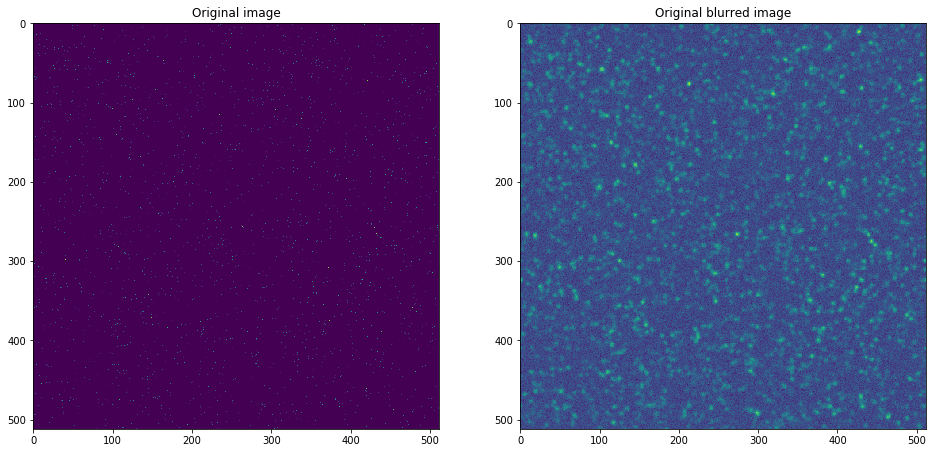

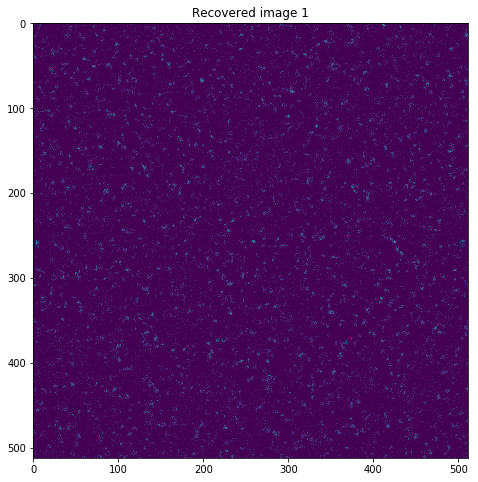

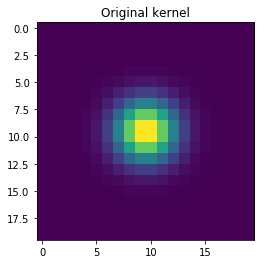

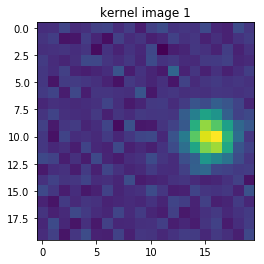

In [262]:
plotplot(A2_data, X2_data, y_noise, original = True, x_0 = x_1, a_0 = a_1)

In [263]:
print(f"Sparsity level of recovered X :{np.sum(X2_data != 0) / np.prod(X2_data.shape)}")
print(f"Sparsity level of Original X :{np.sum(x_1 != 0) / np.prod(x_1.shape)}")

Sparsity level of recovered X :0.227020263671875
Sparsity level of Original X :0.015178680419921875


In [265]:
opts["MaxIter"] = 100
[A2_data, X2_data, b2_data, Psi, psi] = testtest(y_noise, opts, m, n, k, T, 'reweighting-iadm')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:285: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:306: ComplexWarning: Casting complex values to real discards the imaginary part
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:310: ComplexWarning: Casting complex values to real discards the imaginary part


Running the 1-th simulation, Psi_X = 22316.28629379561, Psi_A = 12081.144357374113...
Running the 2-th simulation, Psi_X = 9740.888383985812, Psi_A = 4713.801477533491...
Running the 3-th simulation, Psi_X = 4053.3656257864054, Psi_A = 3749.2182016730767...
Running the 4-th simulation, Psi_X = 3521.3071892942285, Psi_A = 3453.171954627942...
Running the 5-th simulation, Psi_X = 3390.5522665703943, Psi_A = 3390.5522665282137...
Running the 6-th simulation, Psi_X = 3376.5965048894127, Psi_A = 3376.5965048525572...
Running the 7-th simulation, Psi_X = 3375.935229621561, Psi_A = 3375.9352295797...
Running the 8-th simulation, Psi_X = 3378.939281512333, Psi_A = 3378.9392814635694...
Running the 9-th simulation, Psi_X = 3377.742311583192, Psi_A = 3377.742311535641...
Running the 10-th simulation, Psi_X = 3375.9814413153144, Psi_A = 3375.9814412701708...
Running the 11-th simulation, Psi_X = 3374.410966685126, Psi_A = 3374.4109666423165...
Running the 12-th simulation, Psi_X = 3373.2242804222

Running the 24-th simulation, Psi_X = 6474.626308339804, Psi_A = 6450.723946212791...
Running the 25-th simulation, Psi_X = 6824.293109853945, Psi_A = 6696.148961091377...
Running the 26-th simulation, Psi_X = 6576.242551078401, Psi_A = 6542.082084644626...
Running the 27-th simulation, Psi_X = 6510.181005686787, Psi_A = 6464.676041830653...
Running the 28-th simulation, Psi_X = 6499.655039136791, Psi_A = 6427.812939385596...
Running the 29-th simulation, Psi_X = 6463.274434759156, Psi_A = 6418.059833507971...
Running the 30-th simulation, Psi_X = 6742.086211660511, Psi_A = 6642.268508259958...
Running the 31-th simulation, Psi_X = 6535.191655457685, Psi_A = 6509.693876183742...
Running the 32-th simulation, Psi_X = 6467.123164523921, Psi_A = 6431.405641285326...
Running the 33-th simulation, Psi_X = 6449.683197638125, Psi_A = 6392.705994393475...
Running the 34-th simulation, Psi_X = 6448.374818203838, Psi_A = 6404.05571383869...
Running the 35-th simulation, Psi_X = 6462.759032079695

Running the 19-th simulation, Psi_X = 2997.8971554665072, Psi_A = 2990.6634948699893...
Running the 20-th simulation, Psi_X = 2980.8898975554375, Psi_A = 2979.0016227538586...
Running the 21-th simulation, Psi_X = 2977.1498417147086, Psi_A = 2974.419263876799...
Running the 22-th simulation, Psi_X = 2977.992789388223, Psi_A = 2974.648675657108...
Running the 23-th simulation, Psi_X = 2967.92932555119, Psi_A = 2966.5780424541394...
Running the 24-th simulation, Psi_X = 2964.8160393952767, Psi_A = 2962.4240971838917...
Running the 25-th simulation, Psi_X = 2961.761074830807, Psi_A = 2959.8133357865418...
Running the 26-th simulation, Psi_X = 2955.5891689023265, Psi_A = 2953.8428826992417...
Running the 27-th simulation, Psi_X = 2968.7944224254998, Psi_A = 2962.533947981428...
Running the 28-th simulation, Psi_X = 2950.006897491087, Psi_A = 2947.998265779812...
Running the 29-th simulation, Psi_X = 2946.2350286967676, Psi_A = 2943.5205559768597...
Running the 30-th simulation, Psi_X = 295

Running the 13-th simulation, Psi_X = 2346.502995727229, Psi_A = 2344.6473118369095...
Running the 14-th simulation, Psi_X = 2347.5284840766744, Psi_A = 2344.693857870736...
Running the 15-th simulation, Psi_X = 2341.921388186173, Psi_A = 2340.722331262538...
Running the 16-th simulation, Psi_X = 2340.3947449214356, Psi_A = 2338.5046248932913...
Running the 17-th simulation, Psi_X = 2338.224039991312, Psi_A = 2336.8412209762355...
Running the 18-th simulation, Psi_X = 2334.650317664034, Psi_A = 2333.9875223593517...
Running the 19-th simulation, Psi_X = 2332.6750177661497, Psi_A = 2331.6616197945364...
Running the 20-th simulation, Psi_X = 2331.239519966205, Psi_A = 2330.004726326677...
Running the 21-th simulation, Psi_X = 2327.596249623689, Psi_A = 2326.9928085712377...
Running the 22-th simulation, Psi_X = 2325.47920820911, Psi_A = 2324.632140495486...
Running the 23-th simulation, Psi_X = 2326.242264794248, Psi_A = 2324.220194912173...
Running the 24-th simulation, Psi_X = 2321.047

Running the 7-th simulation, Psi_X = 1937.6992279371293, Psi_A = 1936.5834798707906...
Running the 8-th simulation, Psi_X = 1936.190215196104, Psi_A = 1935.8814747749077...
Running the 9-th simulation, Psi_X = 1938.7918725579227, Psi_A = 1936.6163039893595...
Running the 10-th simulation, Psi_X = 1936.5297142885834, Psi_A = 1935.3687087193198...
Running the 11-th simulation, Psi_X = 1936.3362445169785, Psi_A = 1934.6581227350628...
Running the 12-th simulation, Psi_X = 1935.5691113287894, Psi_A = 1934.490855558593...
Running the 13-th simulation, Psi_X = 1933.908314296099, Psi_A = 1933.6561737815064...
Running the 14-th simulation, Psi_X = 1933.6308021709374, Psi_A = 1933.1377574347407...
Running the 15-th simulation, Psi_X = 1933.7625107466672, Psi_A = 1933.0626534462986...
Running the 16-th simulation, Psi_X = 1932.432125604876, Psi_A = 1932.0749503201014...
Running the 17-th simulation, Psi_X = 1932.2296744638109, Psi_A = 1931.530290783241...
Running the 18-th simulation, Psi_X = 19

Running the 1-th simulation, Psi_X = 1734.130075278004, Psi_A = 1733.846419888796...
Running the 2-th simulation, Psi_X = 1735.2420515226045, Psi_A = 1734.2713748658628...
Running the 3-th simulation, Psi_X = 1734.0244919651518, Psi_A = 1733.7180805146343...
Running the 4-th simulation, Psi_X = 1733.8138798504333, Psi_A = 1733.4412726418755...
Running the 5-th simulation, Psi_X = 1733.562289460558, Psi_A = 1733.2807994767077...
Running the 6-th simulation, Psi_X = 1734.128086654634, Psi_A = 1733.4199777019123...
Running the 7-th simulation, Psi_X = 1733.1289550230906, Psi_A = 1732.9407217930113...
Running the 8-th simulation, Psi_X = 1733.1046122375287, Psi_A = 1732.7653181815679...
Running the 9-th simulation, Psi_X = 1733.9189083526583, Psi_A = 1733.0881814740906...
Running the 10-th simulation, Psi_X = 1732.754852827344, Psi_A = 1732.4131000124826...
Running the 11-th simulation, Psi_X = 1732.681780190973, Psi_A = 1732.1357300023867...
Running the 12-th simulation, Psi_X = 1733.3608

Running the 95-th simulation, Psi_X = 1698.9173979400314, Psi_A = 1698.8166089281253...
Running the 96-th simulation, Psi_X = 1699.1397305116993, Psi_A = 1698.9557787386948...
Running the 97-th simulation, Psi_X = 1698.0763355046506, Psi_A = 1697.991501539975...
Running the 98-th simulation, Psi_X = 1697.7174104762198, Psi_A = 1697.511876349397...
Running the 99-th simulation, Psi_X = 1697.500752907973, Psi_A = 1697.2963725106645...
Running the 100-th simulation, Psi_X = 1696.7522835701827, Psi_A = 1696.6844705521007...
Running the 5-th round of reweighting...
Running the 1-th simulation, Psi_X = 1610.1475785502994, Psi_A = 1609.316422239541...
Running the 2-th simulation, Psi_X = 1609.379485852133, Psi_A = 1609.0654100529557...
Running the 3-th simulation, Psi_X = 1609.0333056366067, Psi_A = 1608.8737496923252...
Running the 4-th simulation, Psi_X = 1608.9114572421126, Psi_A = 1608.6622381540315...
Running the 5-th simulation, Psi_X = 1609.093678628162, Psi_A = 1608.6433082904832...
R

Running the 89-th simulation, Psi_X = 1578.3710483708005, Psi_A = 1578.2863215933583...
Running the 90-th simulation, Psi_X = 1578.253309172637, Psi_A = 1578.1684710208008...
Running the 91-th simulation, Psi_X = 1577.8618338006074, Psi_A = 1577.8178622736432...
Running the 92-th simulation, Psi_X = 1577.6530502507708, Psi_A = 1577.5783636101692...
Running the 93-th simulation, Psi_X = 1577.6469051599497, Psi_A = 1577.5247876130293...
Running the 94-th simulation, Psi_X = 1577.171177128123, Psi_A = 1577.1211271672164...
Running the 95-th simulation, Psi_X = 1577.0109777576663, Psi_A = 1576.8993834645928...
Running the 96-th simulation, Psi_X = 1576.909477265439, Psi_A = 1576.799299993313...
Running the 97-th simulation, Psi_X = 1576.5215211996326, Psi_A = 1576.4903035866828...
Running the 98-th simulation, Psi_X = 1576.3521097861415, Psi_A = 1576.2838444020267...
Running the 99-th simulation, Psi_X = 1576.29738711955, Psi_A = 1576.2213806657926...
Running the 100-th simulation, Psi_X =

Running the 83-th simulation, Psi_X = 1481.949945159808, Psi_A = 1481.934457403382...
Running the 84-th simulation, Psi_X = 1481.8515274847434, Psi_A = 1481.8162776394402...
Running the 85-th simulation, Psi_X = 1481.8143442364515, Psi_A = 1481.7741962278644...
Running the 86-th simulation, Psi_X = 1481.6070950587196, Psi_A = 1481.5932169757402...
Running the 87-th simulation, Psi_X = 1481.5117549554168, Psi_A = 1481.4764569202962...
Running the 88-th simulation, Psi_X = 1481.650909952915, Psi_A = 1481.5159471733023...
Running the 89-th simulation, Psi_X = 1481.2589509027184, Psi_A = 1481.2283014503114...
Running the 90-th simulation, Psi_X = 1481.2063293734245, Psi_A = 1481.1113265755178...
Running the 91-th simulation, Psi_X = 1481.1444953939965, Psi_A = 1481.0422134904002...
Running the 92-th simulation, Psi_X = 1480.9571626635366, Psi_A = 1480.9171262821023...
Running the 93-th simulation, Psi_X = 1480.8595874896948, Psi_A = 1480.8213671173908...
Running the 94-th simulation, Psi_X

Running the 77-th simulation, Psi_X = 1446.7318669912174, Psi_A = 1446.5526075627956...
Running the 78-th simulation, Psi_X = 1446.5936142714484, Psi_A = 1446.5343484619302...
Running the 79-th simulation, Psi_X = 1446.47811186152, Psi_A = 1446.4609665810444...
Running the 80-th simulation, Psi_X = 1446.4517978777624, Psi_A = 1446.4076437524927...
Running the 81-th simulation, Psi_X = 1446.499242652898, Psi_A = 1446.415701991937...
Running the 82-th simulation, Psi_X = 1446.3343906653872, Psi_A = 1446.311245955825...
Running the 83-th simulation, Psi_X = 1446.342858305928, Psi_A = 1446.261745597408...
Running the 84-th simulation, Psi_X = 1446.2556087945177, Psi_A = 1446.134811432309...
Running the 85-th simulation, Psi_X = 1446.0595588357323, Psi_A = 1446.0427316391958...
Running the 86-th simulation, Psi_X = 1446.0712385631764, Psi_A = 1445.9975301311238...
Running the 87-th simulation, Psi_X = 1446.0797193946196, Psi_A = 1446.0153588969347...
Running the 88-th simulation, Psi_X = 14

Running the 71-th simulation, Psi_X = 1436.2188848734468, Psi_A = 1436.0758138932943...
Running the 72-th simulation, Psi_X = 1436.0059015314168, Psi_A = 1435.9561305261375...
Running the 73-th simulation, Psi_X = 1436.0661178658843, Psi_A = 1435.9247145056584...
Running the 74-th simulation, Psi_X = 1436.2261006374142, Psi_A = 1436.0170727934035...
Running the 75-th simulation, Psi_X = 1435.9427625914468, Psi_A = 1435.9174904724832...
Running the 76-th simulation, Psi_X = 1436.027328477431, Psi_A = 1435.8967466510596...
Running the 77-th simulation, Psi_X = 1436.1179005910885, Psi_A = 1436.0020761525348...
Running the 78-th simulation, Psi_X = 1435.9368343221186, Psi_A = 1435.9069831746588...
Running the 79-th simulation, Psi_X = 1436.0004570873546, Psi_A = 1435.8842670580912...
Running the 80-th simulation, Psi_X = 1436.0378370366968, Psi_A = 1435.9239861667975...
Running the 81-th simulation, Psi_X = 1435.8792720599185, Psi_A = 1435.8571176623811...
Running the 82-th simulation, Psi

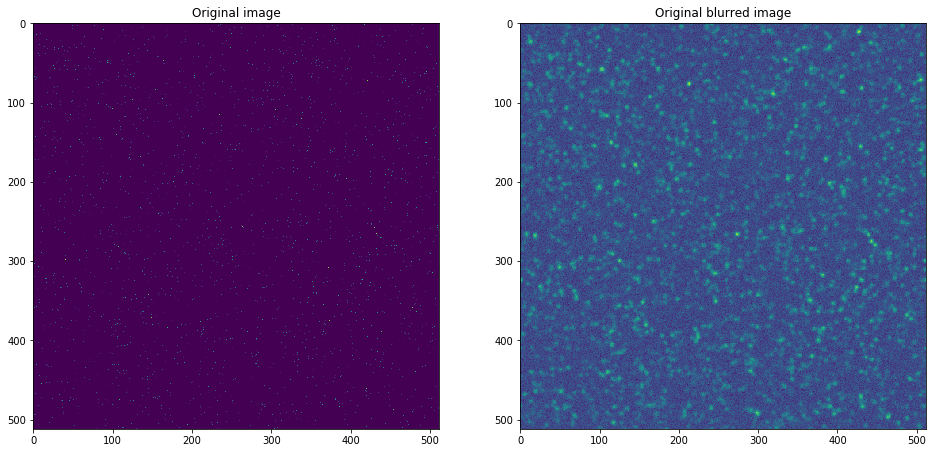

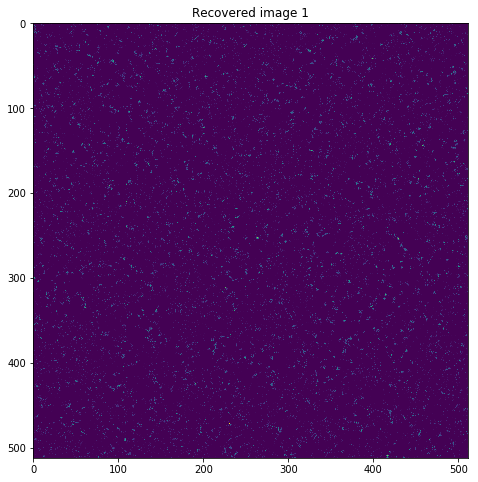

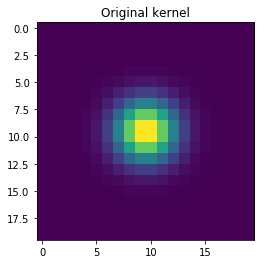

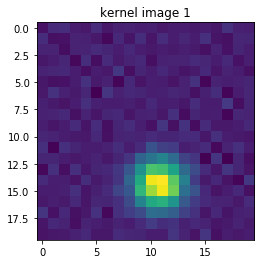

In [266]:
plotplot(A2_data, X2_data, y_noise, original = True, x_0 = x_1, a_0 = a_1)

In [267]:
print(f"Sparsity level of recovered X :{np.sum(X2_data != 0) / np.prod(X2_data.shape)}")
print(f"Sparsity level of Original X :{np.sum(x_1 != 0) / np.prod(x_1.shape)}")

Sparsity level of recovered X :0.12816619873046875
Sparsity level of Original X :0.015178680419921875
